# Исследование компьютерных игр

Интернет-магазин «Стримчик» продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Перед вами данные до 2016 года. Требуется выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

**Цель исследования**:  выявить определяющие успешность игры закономерности

**Ход исследования**

1. Предобработка данных
2. Исследовательский анализ данных
3. Составление портрета каждого региона
4. Проверка гипотез

### Общая информация

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import re
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_rows', 80)

In [3]:
data = pd.read_csv('/datasets/games.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
data.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


### Предобработка данных

Для удобства дальнейшей работы приведем названия столбцов к нижнему регистру

In [6]:
data.columns = data.columns.str.lower()
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Разберемся с пропусками

In [7]:
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

In [8]:
(
    (data.isna().mean()*100)
    .sort_values(ascending=False)
    .to_frame()
    .rename(columns = {0:'percent_space'})
    .style.background_gradient('coolwarm').format("{:.1f}")
)

,percent_space
critic_score,51.3
rating,40.5
user_score,40.1
year_of_release,1.6
name,0.0
genre,0.0
platform,0.0
na_sales,0.0
eu_sales,0.0
jp_sales,0.0


Как мы видим, больше всего пропусков в столбцах с рейтингом и оценкой

Рассмотрим пропуски в столбце `year_of_release`

In [9]:
data_year_missed = data[data['year_of_release'].isna()]
data_year_missed

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,tbd,E10+
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Посмотрим на платформы тех игр, у которых отсутствует год выпуска

In [10]:
data_year_missed['platform'].unique()

array(['PS2', 'Wii', '2600', 'X360', 'GBA', 'PC', 'PS3', 'PS', 'PSP',
       'XB', 'GB', 'DS', 'GC', '3DS', 'N64', 'PSV'], dtype=object)

Как мы видим, большинство платформ - это платформы, у которых поддержка прекращена до 2016 года (кроме PC,3DS,PSV), следовательно, эти платформы уже неактуальны, и данные по ним можно не рассматривать, так как они не помогут спрогнозировать продажи на 2017 год

In [11]:
list_of_useless_platforms = np.setdiff1d(data_year_missed['platform'].unique(), ['PC','3DS','PSV'])
data = data.loc[((~data['platform'].isin(list_of_useless_platforms)) & (data['year_of_release'].isna())) | (~data['year_of_release'].isna())]
data[data['year_of_release'].isna()]['platform'].unique()

array(['PC', '3DS', 'PSV'], dtype=object)

Теперь посмотрим на оставшиеся пропуски в столбце года выпуска

In [12]:
print('Количество пропусков в столбце года выпуска = ', len(data[data['year_of_release'].isna()]))

Количество пропусков в столбце года выпуска =  26


Посмотрим на пропуски в столбце `critic_score`

In [13]:
data_critic_missed = data[data['critic_score'].isna()]
data_critic_missed

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Проверим у скольки игр отсутствуют все данные об оценках

In [14]:
print('Количество игр, у которых пропущены и оценки от критиков, и от пользователей = ', data.loc[data['critic_score'].isna() & data['user_score'].isna()].shape[0])
print('Количество игр, у которых пропущена оценка от пользователей', data[data['user_score'].isna()].shape[0])
print('Количество игр, у которых пропущена оценка от критиков', data[data['critic_score'].isna()].shape[0])

Количество игр, у которых пропущены и оценки от критиков, и от пользователей =  6578
Количество игр, у которых пропущена оценка от пользователей 6612
Количество игр, у которых пропущена оценка от критиков 8470


<AxesSubplot:>

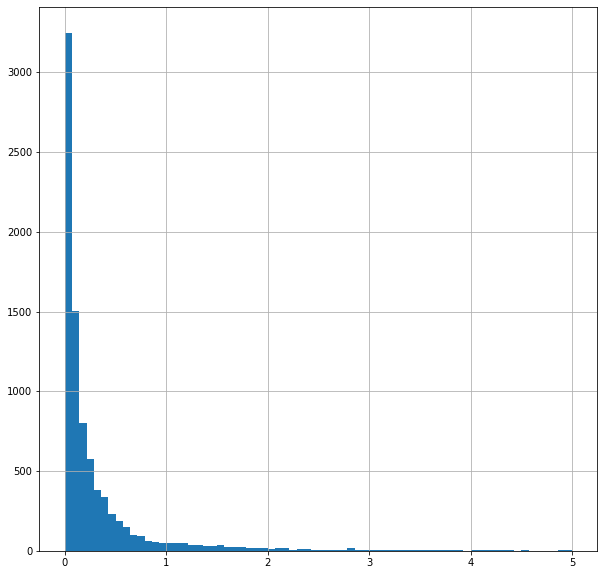

In [15]:
(data_critic_missed['na_sales'] + data_critic_missed['jp_sales'] + data_critic_missed['eu_sales'] + data_critic_missed['other_sales']).hist(bins = 70, figsize = (10,10),range = (0,5))

In [16]:
data_critic_not_user_missed = data.loc[(data['critic_score'].isna()) & (~ data['user_score'].isna())]

In [17]:
print('Количество пропусков в оценке от критиков у игр, у которых присутствует оценка от пользователей', data_critic_not_user_missed.shape[0])
data_critic_not_user_missed['user_score'].value_counts()

Количество пропусков в оценке от критиков у игр, у которых присутствует оценка от пользователей 1892


tbd    1322
7.8      26
8        23
7        23
7.6      19
       ... 
2.7       1
2.4       1
1.2       1
1.7       1
9.3       1
Name: user_score, Length: 85, dtype: int64

<AxesSubplot:>

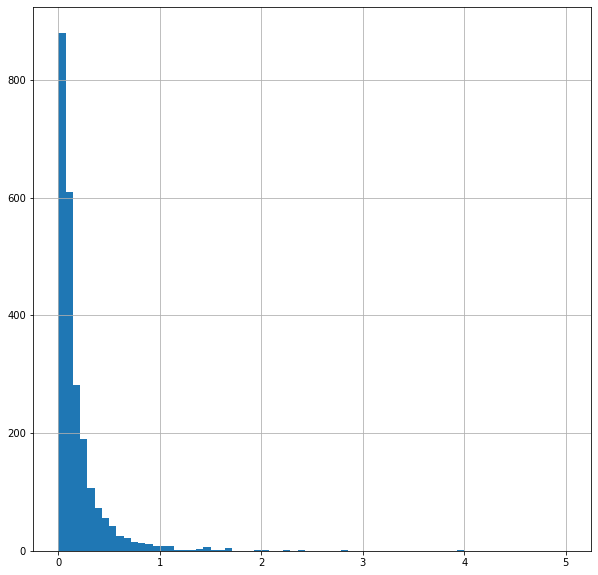

In [18]:
data_tbd_user_score = data[data['user_score'] == 'tbd']
(data_tbd_user_score['na_sales'] + data_tbd_user_score['jp_sales'] + data_tbd_user_score['eu_sales'] + data_tbd_user_score['other_sales']).hist(bins = 70, figsize = (10,10),range = (0,5))

Исходя из полученных данных, можно сделать вывод, что пропуски в обоих столбцах оценки в основном у непопулярных игр на данных платформах, что достаточно логично, а пропуски только в столбце оценки критиков в большинстве у игр, у которых в столбце `user_score` стоит 'tbd', что значит, что голосов пользователей недостаточно, чтобы поставить пользовательскую оценку, значения 'tbd' в столбце `user_score` можно расценивать как Nan, опять же это значит что игра на данной платформе (или впринципе сама игра) не заинтересовала пользователей

In [19]:
data['user_score'] = data['user_score'].replace({'tbd' : np.NaN})
data['user_score'] = data['user_score'].astype('float')
sum(data['user_score'].isna())

8990

Оценка игры - вещь субъективная, поэтому мы можем заполнить данные пропуски в столбцах `user_score` и `critic_score` только если есть данные об этих же играх на других платформах.

Будем заполнять пропуски в том случае, если есть оценки от критиков на других платформах и их более 2 и стандартное отклонение этих оценок меньше 1

In [20]:
data_critic_score_not_null = data.loc[~data['critic_score'].isna()]

In [21]:
def fill_critic (x):
    if(not pd.isnull(x['critic_score'])):
        return x['critic_score']
    name = x['name']
    if(data_critic_score_not_null[data_critic_score_not_null['name'] == name].shape[0] > 2) and (np.std(data_critic_score_not_null[data_critic_score_not_null['name'] == name]['critic_score']) < 1):
        return data_critic_score_not_null[data_critic_score_not_null['name'] == name]['critic_score'].mean()
    return x['critic_score']
data['critic_score'] = data.apply(fill_critic, axis = 1)
sum(data['critic_score'].isna())

8416

Аналогично заполним пропуски в столбце `user_score`

In [22]:
data_user_score_not_null = data.loc[~data['user_score'].isna()]

In [23]:
count = 0
for name in data[data['user_score'].isna()]:
    if(data_user_score_not_null[data_user_score_not_null['name'] == name].shape[0] > 2) and (np.std(data_user_score_not_null[data_user_score_not_null['name'] == name]['user_score']) < 1):
        count += 1
print(count)

0


К сожалению, оценки пользователей достаточно сильно разнятся для того чтобы заполнить пропуски, следовательно `user_score` остается незаполненным

Теперь рассмотрим пропуски в столбце `rating`

In [24]:
data_rating_missed = data[data['rating'].isna()]
data_rating_missed

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Пропуски в столбце с возрастным рейтингом могут быть по причине того что рейтинг мог быть выставлен не компанией ESRB (в основном распространена в Америке), или же игра слишком старая, поэтому не имеет рейтинга, так как ESRB начали работать в 1994 

In [25]:
data_rating_not_null = data[~data['rating'].isna()]
strange_rating_names = []
count = 0
for name in data['name']:
    if(len(data_rating_not_null[data_rating_not_null['name'] == name]['rating'].unique()) > 1):
        strange_rating_names.append(name)
print('Количество игр у которых разное возрастное ограничение ', len(strange_rating_names))

Количество игр у которых разное возрастное ограничение  709


Так как в основном производители стараются делать одну и ту же игру на разных платформах приблизительно одинаковой, то мы можем заполнять пропуски, если есть данные о рейтингах на других платформах. Однако игры могут иметь разное ограничение на разных платформах, что может зависеть от разницы в версиях игры на разных платформах, например в связи с изменениями в курирующей разработку компании или в связи с тем что год релиза версий на разных платформах сильно отличается, соответственно ограничения на каждую версию могли получаться отдельно, будем заполнять пропуски только если год ближайшей версии о которой есть информация отличается максимум на 2 года и если у всех предыдущих версий было одно возрастное ограничение 

In [26]:
def fill_rating(x):
    if(not pd.isnull(x['rating'])):
        return x['rating']
    name = x['name']
    if (len(data_rating_not_null[data_rating_not_null['name'] == name]) > 1) and (not pd.isnull(x['year_of_release'])):
        temp_list = list(data_rating_not_null[data_rating_not_null['name'] == name]['year_of_release'].dropna())
        temp_list.append(x['year_of_release'])
        temp_list = sorted(temp_list)
        index_x = temp_list.index(x['year_of_release'])
        one = abs(temp_list[(index_x-1  if index_x > 0 else index_x)] - x['year_of_release'] + (3000 if index_x == 0 else 0))
        two = abs(temp_list[(index_x+1 if index_x + 1 < len(temp_list) else index_x )] - x['year_of_release'] + (3000 if index_x +1 == len(temp_list) else 0))
        if (min(abs(temp_list[(index_x-1  if index_x > 0 else index_x)] - x['year_of_release'] + (3000 if index_x == 0 else 0)), abs(temp_list[(index_x+1 if index_x + 1 < len(temp_list) else index_x )] - x['year_of_release'] + (3000 if index_x +1 == len(temp_list) else 0))) <=2 )\
         and (len(data_rating_not_null[data_rating_not_null['name'] == name]['rating'].unique()) == 1):
            return data_rating_not_null[data_rating_not_null['name'] == name]['rating'].unique()[0]
    return x['rating']

data['rating'] = data.apply(fill_rating, axis = 1)
sum(data['rating'].isna())

6544

Для того чтобы в будущем анализировать эти игры вместе с теми, у которых рейтинг установлен, заполним пропуски значением 'No rating'

In [27]:
data['rating'] = data['rating'].fillna('No rating')
len(data[data['rating'].isna()])

0

Посмотрим на пропуски в столбце `name`

In [28]:
data[data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,No rating
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,No rating


Можно предположить, что первая игра - это Mortal Combat 2, вторая - одна из тех, которые продавались только в Японии. Однако так как эти игры были выпущены в 1993, они уже неактуальны для прогнозирования продаж на 2017 год, поэтому удалим эти данные

In [29]:
data = data.dropna(subset = ['name'])

Далее рассмотрим типы данных в датасете

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16470 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16470 non-null  object 
 1   platform         16470 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16470 non-null  object 
 4   na_sales         16470 non-null  float64
 5   eu_sales         16470 non-null  float64
 6   jp_sales         16470 non-null  float64
 7   other_sales      16470 non-null  float64
 8   critic_score     8056 non-null   float64
 9   user_score       7482 non-null   float64
 10  rating           16470 non-null  object 
dtypes: float64(7), object(4)
memory usage: 1.5+ MB


Тип float не подходит для описания года, однако из-за того что в этом столбце присутствуют пропуски, мы не можем заменить тип там, все остальные типы данных корректны

Для удобства дальнейшей работы создадим столбец с суммарным количеством проданных игр

In [31]:
data['total_sales'] = data[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,No rating,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,No rating,31.38


## Исследовательский анализ данных

Посмотрим, сколько игр выпускалось в разные года

In [32]:
data.pivot_table(index = 'year_of_release', values = 'na_sales',aggfunc='count').sort_values(by = 'na_sales')

,na_sales
year_of_release,
1980.0,9
1984.0,14
1985.0,14
1988.0,15
1990.0,16
1987.0,16
1989.0,17
1983.0,17
1986.0,21


Text(0, 0.5, 'Количество')

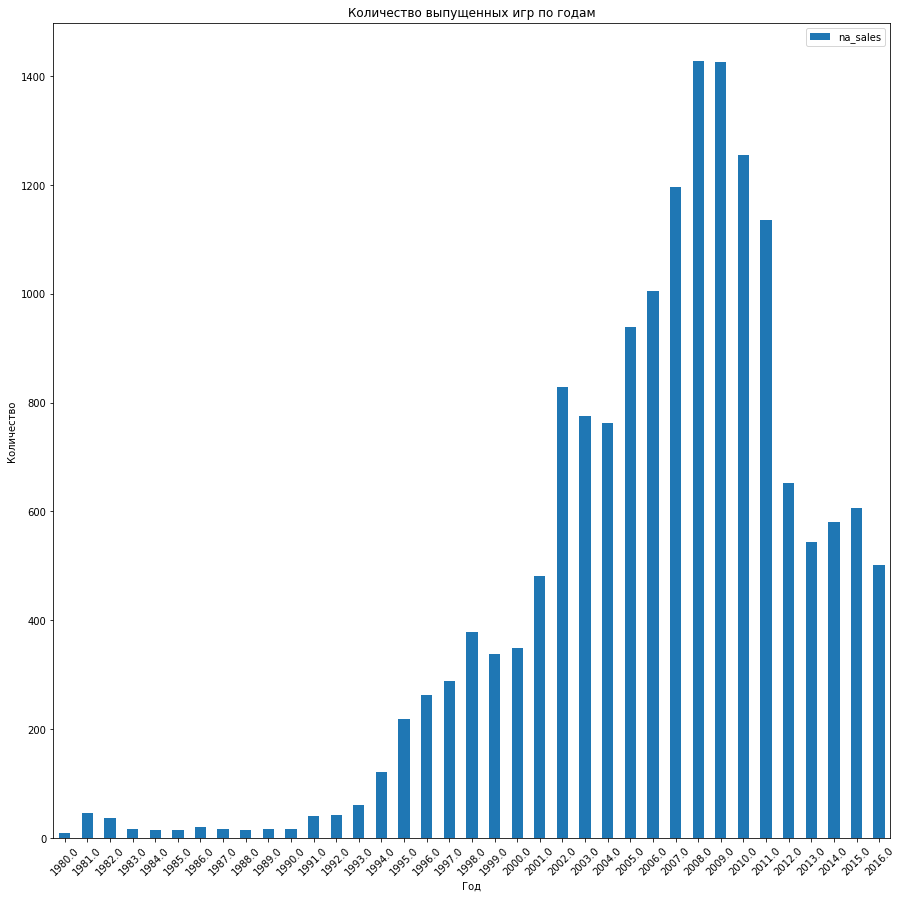

In [33]:
data.pivot_table(index = 'year_of_release', values = 'na_sales',aggfunc='count').plot(kind = 'bar', rot = 45, figsize = (15,15))
plt.title('Количество выпущенных игр по годам')
plt.xlabel('Год')
plt.ylabel('Количество')

По графику видим ,что пик выпуска игр пришелся на 2007-2011, после 2011 видим резкий спад в выпуске игр

Далее посмотрим как менялись продажи игр по платформам

In [34]:
data.pivot_table(index = 'platform', values = 'total_sales',aggfunc='sum').sort_values(by = 'total_sales',ascending = False)

,total_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


Платформы с наибольшими продажами - PS2, X360, PS3, Wii,DS

Посмотрим на распределение продаж по годам на этих платформах

In [35]:
top_platforms = ['PS2', 'X360', 'PS3', 'Wii','DS']
data_top_platforms = data.loc[data['platform'].isin(top_platforms)].pivot_table(index = ['platform','year_of_release'], values = 'total_sales', aggfunc='sum').reset_index()

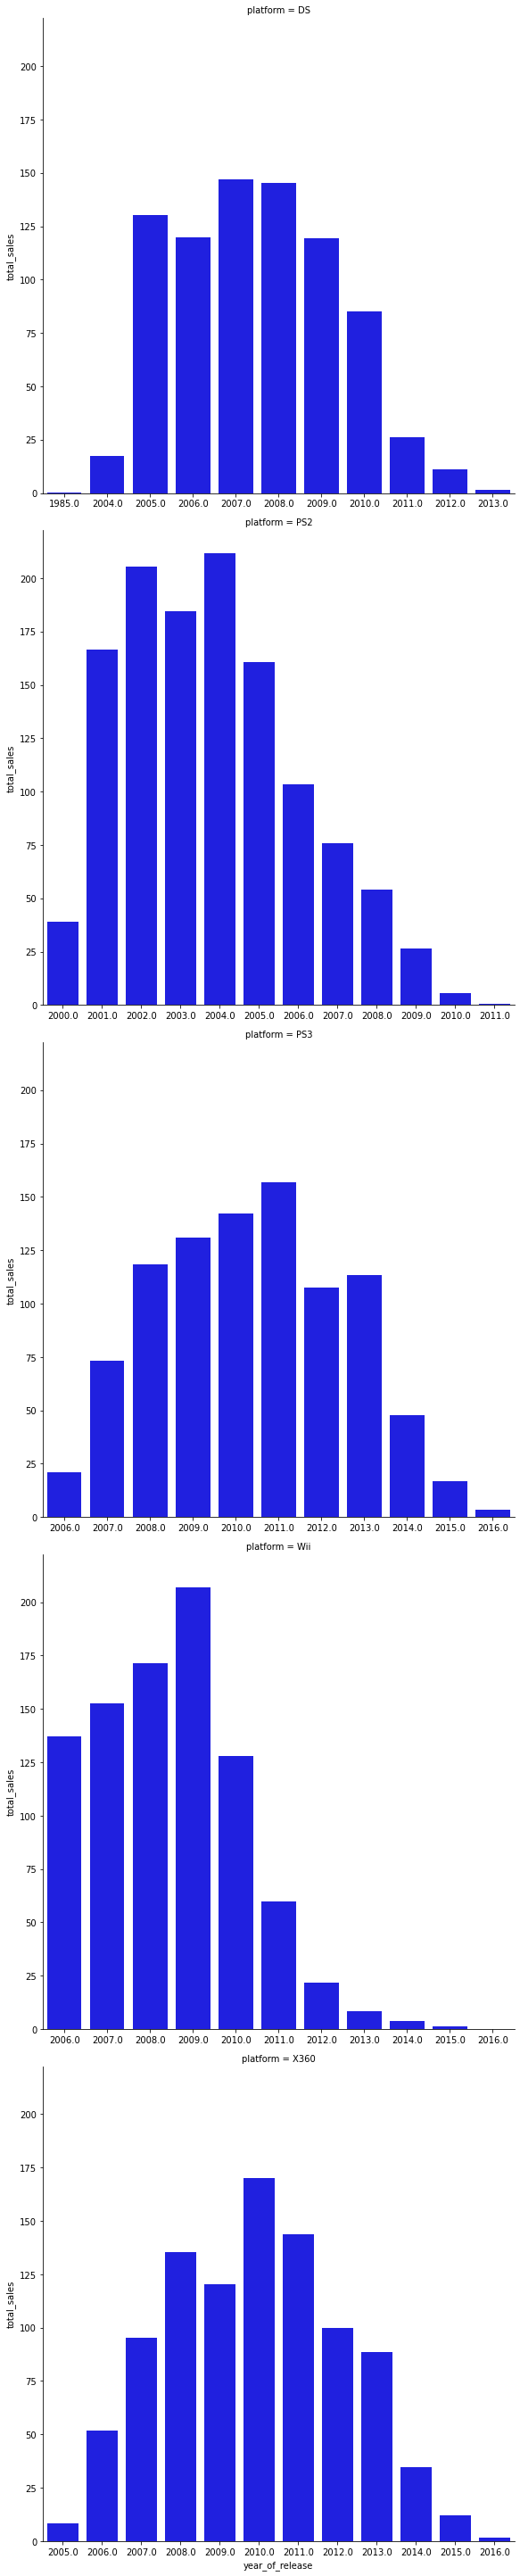

In [36]:
g = sns.catplot(x="year_of_release", y='total_sales', row="platform",
                   data=data_top_platforms,kind ='bar', color = 'blue',height = 8, sharex = False)

Видим, что у этих платформ продажи новых игр на 2016 год либо нулевые, либо очень маленькие по сравнению с продажами ранее, если динамика продолжится, то можно будет констатировать факт, что срок жизни каждой из платформ примерно лет  10-12, далее они скорее всего уже выходят из моды и им на смену приходят более современные платформы. Следует заметить, что у популярных платформ пик продаж достигается на 4-6 год, далее динамика уже идет на спад. 

Также странным является 1985 года на платформе DS, так как дата выхода этой платформы на рынок - 2004 год, в наших данных нет других данных об этой игре, а также у нее очень много пропусков в столбцах, поэтому удалим эту игру

In [37]:
data.loc[(data['year_of_release'] == 1985) & (data['platform'] == 'DS')]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
15957,Strongest Tokyo University Shogi DS,DS,1985.0,Action,0.0,0.0,0.02,0.0,NaN,NaN,No rating,0.02


In [38]:
data[data['name'] == 'Strongest Tokyo University Shogi DS']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
15957,Strongest Tokyo University Shogi DS,DS,1985.0,Action,0.0,0.0,0.02,0.0,NaN,NaN,No rating,0.02


In [39]:
data = data[data['name'] != 'Strongest Tokyo University Shogi DS']

In [40]:
statistic = data.pivot_table(index = 'platform', values = 'year_of_release', aggfunc=['min','max'])
statistic.columns = ['min_year','max_year']
statistic['actual_years'] = statistic['max_year'] - statistic['min_year'] + 1
statistic

,min_year,max_year,actual_years
platform,,,
2600,1980.0,1989.0,10.0
3DO,1994.0,1995.0,2.0
3DS,2011.0,2016.0,6.0
DC,1998.0,2008.0,11.0
DS,2004.0,2013.0,10.0
GB,1988.0,2001.0,14.0
GBA,2000.0,2007.0,8.0
GC,2001.0,2007.0,7.0
GEN,1990.0,1994.0,5.0


<AxesSubplot:xlabel='year_of_release'>

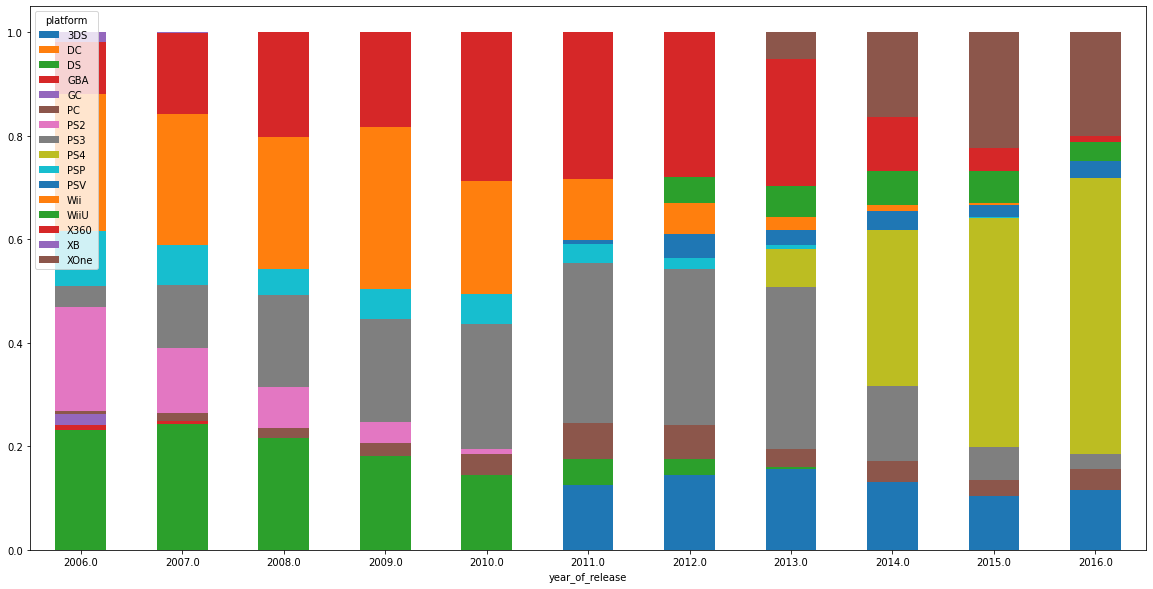

In [41]:
data = data[data['year_of_release']>=2006]
cross_tab_prop = pd.crosstab(index=data['year_of_release'],
                             columns=data['platform'],
                             values = data['total_sales'],
                             aggfunc='sum',
                             normalize="index")
cross_tab_prop.plot.bar(rot = 0,figsize = (20,10), stacked = True)

Так как нам нужно спрогнозировать продажи на 2017 год, то мы не будем рассматривать игры до 2006 года, так как они или были выпущены на неактуальной сейчас платформе, или же если они были популярными, то есть уже скорее всего следующая часть этой игры, возможно на более современной платформе, и тогда эта часть неактуальна, а если эта игра старая и к тому же еще и непопулярная, тогда с большой долей вероятности ей и не заинтересуются в 2017. 
Также учитывая, что мы прогнозируем продажи на 2017 год,а обычно для задач прогнозирования, особенно в такой переменчивой индустрии, используют данные за последние 2-4 года, а начиная с 2012 как раз произошли большие изменения в структуре рынка - резкий спад в количестве новых игр, и если мы будем рассматривать игры до 2012 года, то различие в количестве продаж в 2007-2011 и 2012-2016 могут дать неточные результаты, также мы видим, что в 2011-2012 начинает меняться структура рынка с точки зрения популярности платформ.

In [42]:
data = data[data['year_of_release'] >= 2012]
len(data)

2886

Теперь уже на актуальном для нас временном промежутке посмотрим, какие платформы лидируют по продажам

In [43]:
data.pivot_table(index = 'platform', values = 'total_sales',aggfunc='sum').sort_values(by = 'total_sales',ascending = False)

,total_sales
platform,
PS4,314.14
PS3,288.79
X360,236.54
3DS,194.61
XOne,159.32
WiiU,82.19
PC,62.65
PSV,49.18
Wii,35.37


Лидирующие по продажам платформы - PS4, PS3, X360,3DS, XOne. Следует также отметить, что как и ожидалось, количество платформ значительно уменьшилось

Посмотрим на динамику продаж на этих 5 платформах

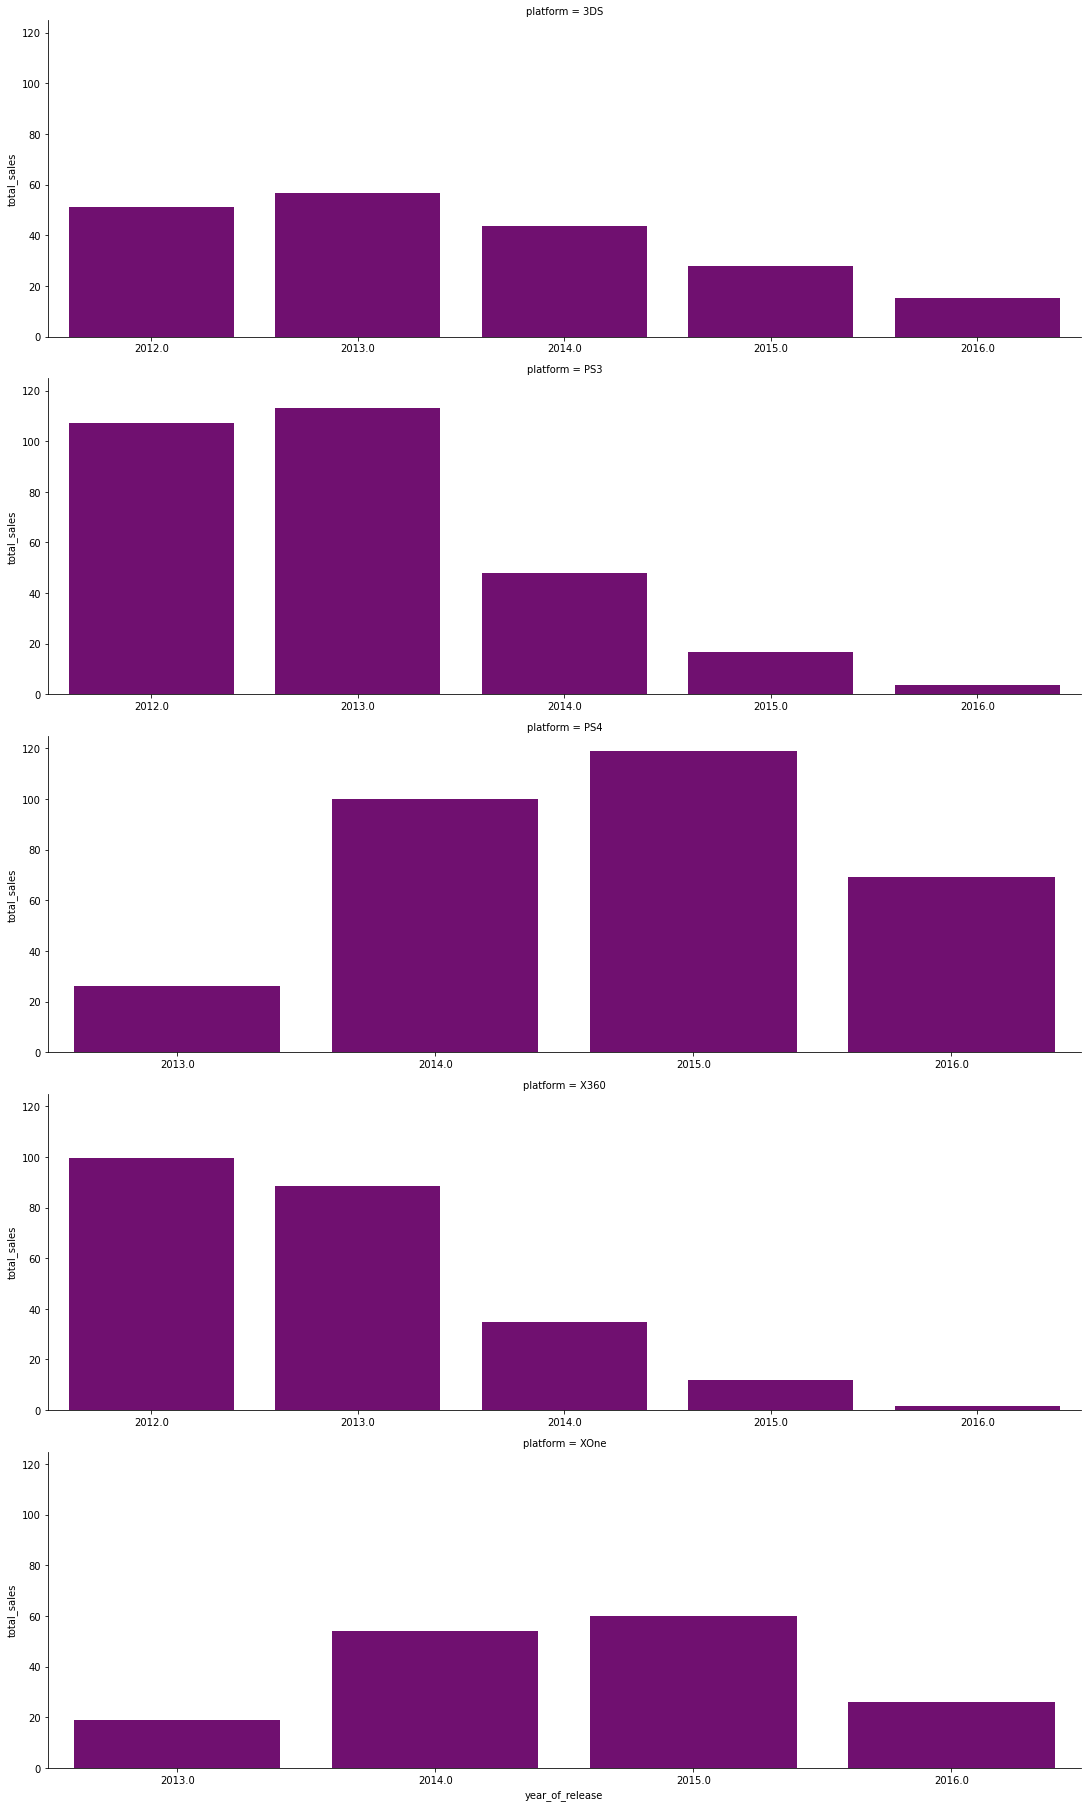

In [44]:
top_platforms = ['X360','PS3','XOne','3DS','PS4']
data_top_platforms = data.loc[data['platform'].isin(top_platforms)].pivot_table(index = ['platform','year_of_release'], values = 'total_sales', aggfunc='sum').reset_index()
g = sns.catplot(x="year_of_release", y='total_sales', row="platform",
                   data=data_top_platforms,kind ='bar', color = 'purple',height = 5, sharex = False, aspect = 3)

Следует отметить, что так как данные за 2016 год неполные, то мы не можем делать выводы о спаде количества продаж игр этого года, однако мы можем заметить рост продаж у платформ XOne,PS4 за 2013-2015, спад продаж у платформ X360,PS3, и небольшой спад у платформы 3DS, спад у платформ X360,PS3 и рост XOne, PS4 можно объяснить тем, что XOne - замена X360, а PS4 - замена PS3

<AxesSubplot:xlabel='year_of_release'>

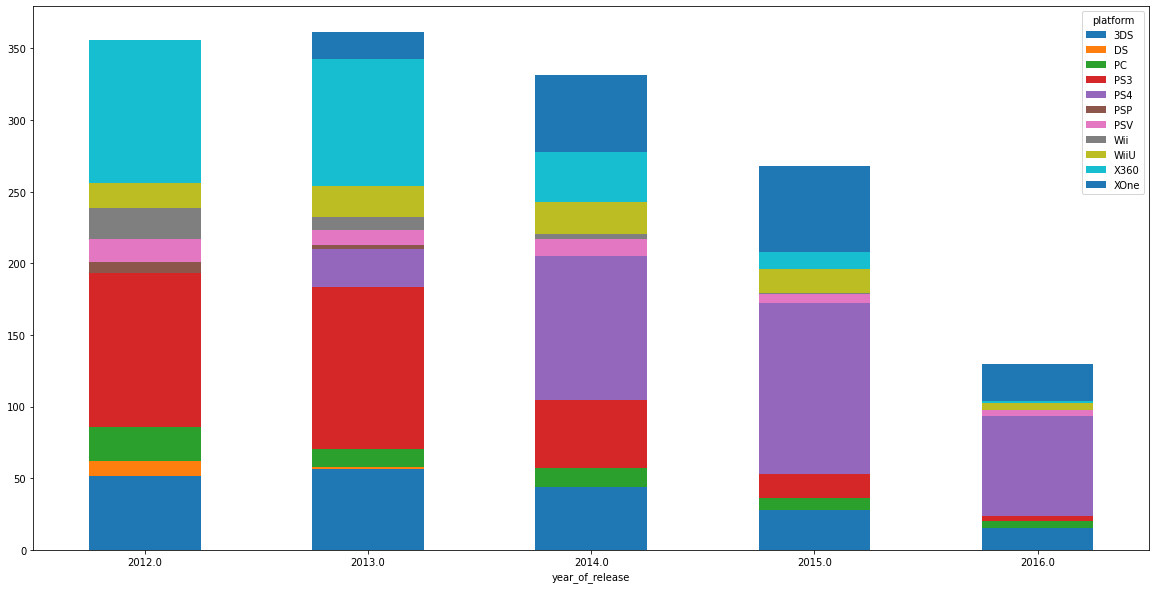

In [45]:
data.pivot_table(index = 'year_of_release', columns = 'platform', values = 'total_sales', aggfunc='sum').fillna(0).plot.bar(rot = 0,figsize = (20,10), stacked = True)

Как мы видим по графику - платформы PS4, 3DS, XOne - наиболее перспективны. Игры на других платформах выпускают значительно меньше (или же вообще не выпускают), что свидетельствует о том, что платформа потеряла актуальность, или же современные игры на этих платформах не покупают, что также свидетельствует о ее неперспективности. О перспективности указанных платформ говорит также то, что они являются преемниками более старых очень популярных платформ PS3, DS, X360

Рассмотрим глобальные продажи игр по платформам

<AxesSubplot:xlabel='platform', ylabel='total_sales'>

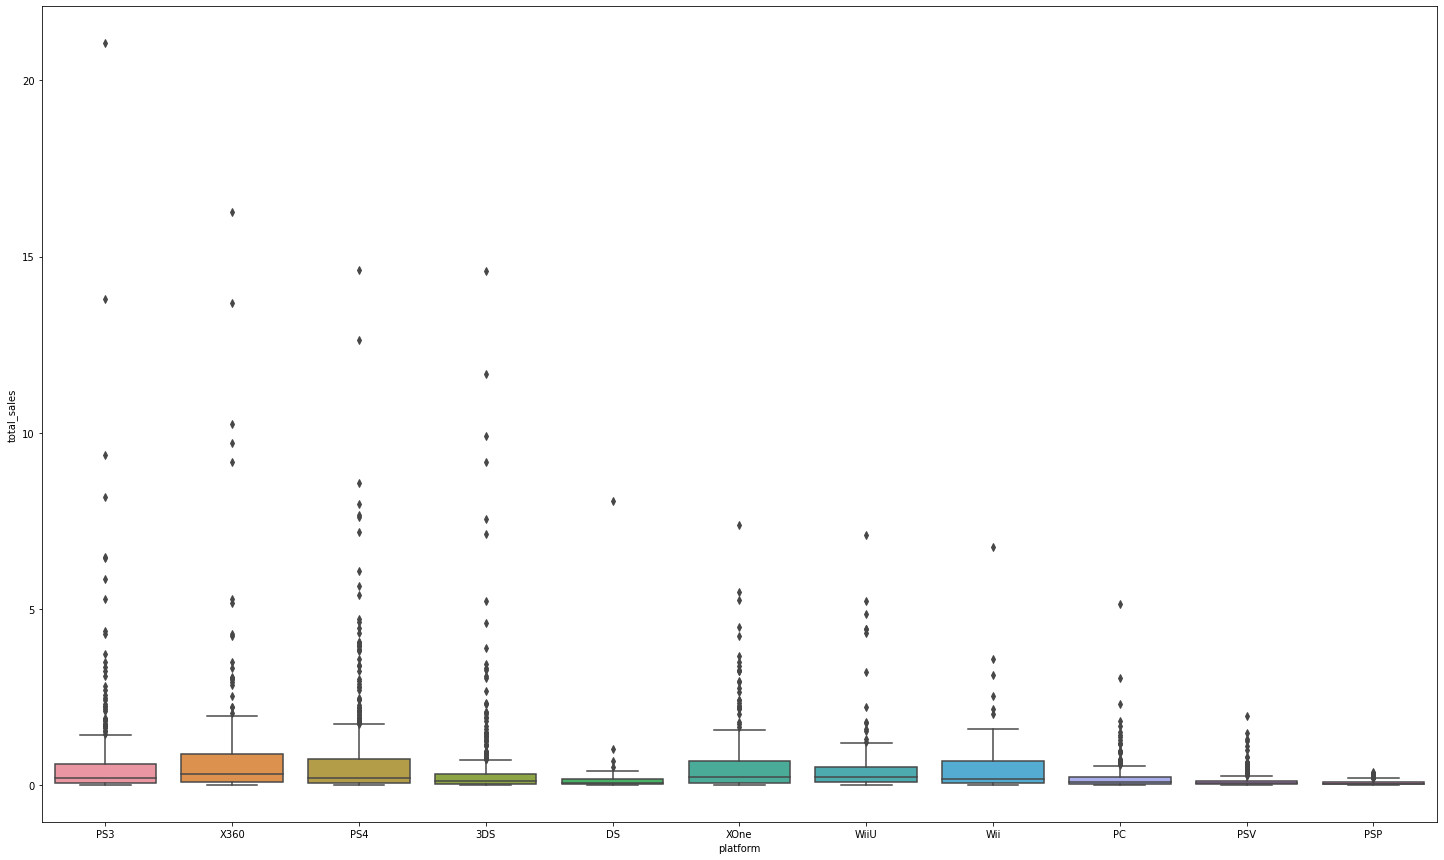

In [46]:
plt.figure(figsize=(25,15))
sns.boxplot(x = 'platform', y = 'total_sales', data = data)

In [47]:
data[data['total_sales'] > 20]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013.0,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05


Grand Theft Auto V - безусловный лидер в играх по продажам, примем во внимание то, что на графике есть такие выдающиеся выбросы, возможно часть бюджета можно будет направить на рекламу этих очень популярных игр, и рассмотрим основную массу игр (без выбросов)

<AxesSubplot:xlabel='platform', ylabel='total_sales'>

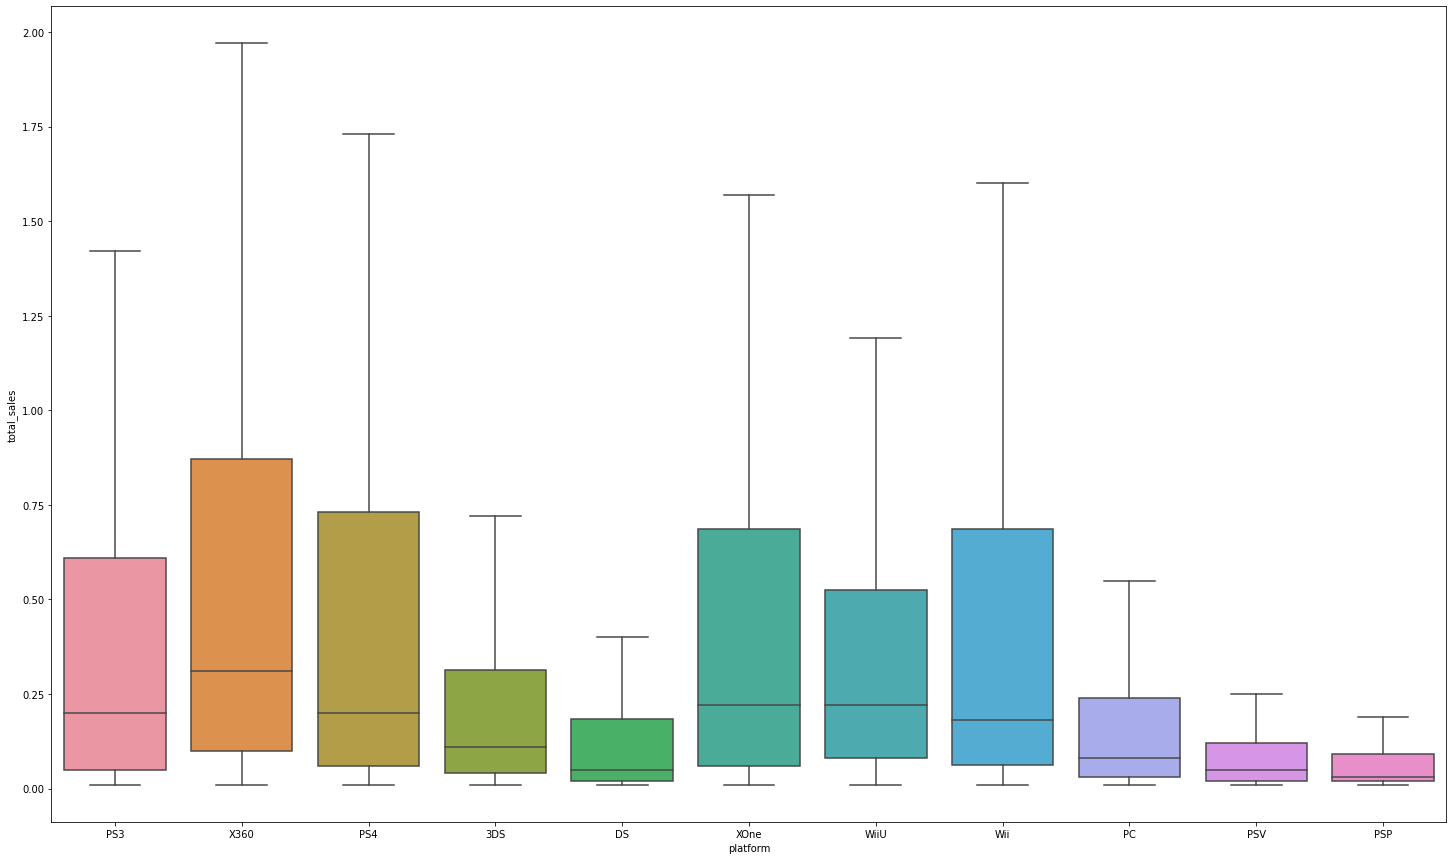

In [48]:
plt.figure(figsize=(25,15))
sns.boxplot(x = 'platform', y = 'total_sales', data = data,showfliers = False)

Видим, что в основном медианное значение общего количества продаж у всех платформ достаточно низкое, это говорит о том, что большинство игр не производят фурор, однако следует заметить, что практически у каждой платформы есть огромные выбросы. Следует также отметить, что платформы XOne, X360 имеют одну из самых больших медиан и квартилей, самые низкие - у PSP, PSV, DS, так как в период с 2012 года PSP и DS уже считались устаревшими, а платформа PSV просто не пользовалась большим таким большим спросом, как например та же XOne

In [49]:
top_for_platforms = data.groupby('platform')[['name','total_sales','platform']].head(5).sort_values(by = 'platform')
np.sort(list(top_for_platforms['name']))

array([" Frozen: Olaf's Quest", 'Animal Crossing: New Leaf',
       "Assassin's Creed III: Liberation",
       'Call of Duty Black Ops: Declassified',
       'Call of Duty: Advanced Warfare', 'Call of Duty: Advanced Warfare',
       'Call of Duty: Black Ops 3', 'Call of Duty: Black Ops 3',
       'Call of Duty: Black Ops II', 'Call of Duty: Black Ops II',
       'Call of Duty: Ghosts', 'Call of Duty: Ghosts',
       'Dai-2-Ji Super Robot Taisen Z Saisei-hen', 'Diablo III',
       'FIFA 14', 'FIFA 16', 'FIFA Soccer 13', 'FIFA Soccer 13',
       'Fallout 4', 'Grand Theft Auto V', 'Grand Theft Auto V',
       'Grand Theft Auto V', 'Grand Theft Auto V', 'Guild Wars 2',
       'Halo 4', 'Halo 5: Guardians', 'Just Dance 2014', 'Just Dance 4',
       'LEGO Batman 2: DC Super Heroes', 'LittleBigPlanet PS Vita',
       'Mario Kart 8', 'Mario Party 9', 'Minecraft', 'Minecraft',
       'Moshi Monsters: Moshlings Theme Park', 'New Super Mario Bros. 2',
       'New Super Mario Bros. U', 'Nintendo L

In [50]:
(top_for_platforms.sort_values(by = 'name'))

,name,total_sales,platform
3862,Frozen: Olaf's Quest,0.51,DS
73,Animal Crossing: New Leaf,9.17,3DS
1485,Assassin's Creed III: Liberation,1.31,PSV
1294,Call of Duty Black Ops: Declassified,1.47,PSV
92,Call of Duty: Advanced Warfare,7.66,PS4
179,Call of Duty: Advanced Warfare,5.26,XOne
31,Call of Duty: Black Ops 3,14.63,PS4
99,Call of Duty: Black Ops 3,7.39,XOne
34,Call of Duty: Black Ops II,13.79,PS3
35,Call of Duty: Black Ops II,13.68,X360


Как мы видим, очень многие игры повторяются, то есть в топе всех платформ в основном стоят просто популярные игры, которые известны и продаваемы на многих других платформах

Рассмотрим самые прибыльные платформы и посмотрим на зависимость между отзывами и продажами

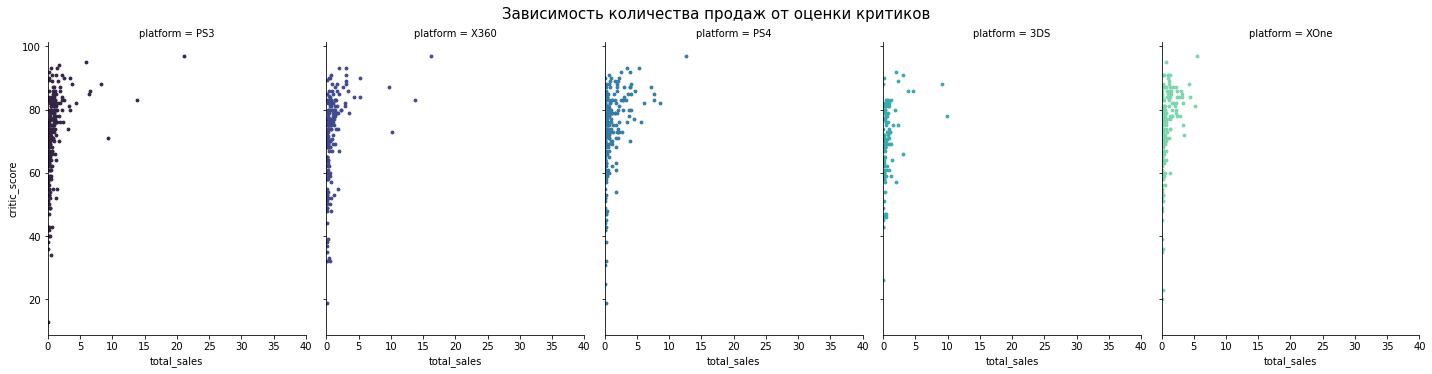

Коэффициент корреляции для платформы X360  равен =  0.35304486213952757
Коэффициент корреляции для платформы PS3  равен =  0.3284599949323674
Коэффициент корреляции для платформы XOne  равен =  0.4081030538671795
Коэффициент корреляции для платформы 3DS  равен =  0.3119282724976071
Коэффициент корреляции для платформы PS4  равен =  0.40360298218770574


In [51]:
g = sns.FacetGrid(data=data.loc[data['platform'].isin(top_platforms)], col='platform', height=5, aspect=0.8, hue = 'platform', palette='mako',xlim=(0,40))
g.map(plt.scatter, 'total_sales','critic_score', s = 8)
g.fig.suptitle('Зависимость количества продаж от оценки критиков',
               y = 1.03,
               fontsize = 15)
plt.show()
for platform in top_platforms:
    print('Коэффициент корреляции для платформы', platform, ' равен = ', data[data['platform'] == platform]['total_sales'].corr(data[data['platform'] == platform]['critic_score'] ))

Видим, что в общем корреляция достаточно слабая - четкой линейной зависимости между оценкой критиков и количеством продаж нет, однако следует заметить, что если оценка игры меньше 60 со стороны критика, то тогда она непопулярна, и все популярные игры в основном имеют оценку больше 60-65, также очень много видно игр, которые имеют отличную оценку от критиков, но при этом ее продажи очень малы, следовательно хорошая оценка от критика лишь расширяет потолок возможных продаж, но все равно достаточно вероятно, что игра не будет популярной. 

Самый большой коэффициент корреляции (самая линейная зависимость) у платформы XOne, самая низкая - у 3DS, также нужно отметить, что играм платформы 3DS ставят достаточно мало хороших оценок. Также следует заметить, что топ-игры X360, PS3 и PS4 были "предугаданы" критиками точнее всего

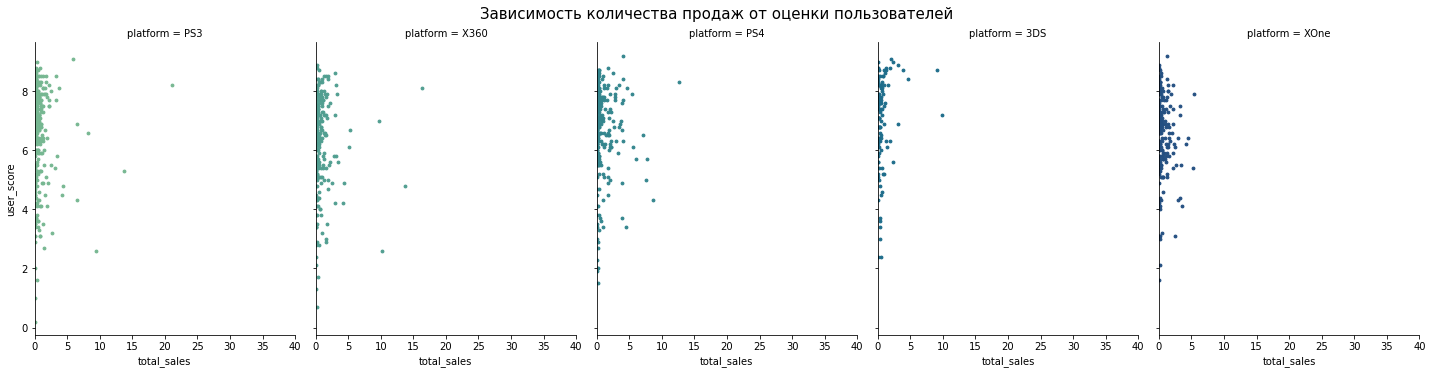

Коэффициент корреляции для платформы X360  равен =  0.0061639786462133256
Коэффициент корреляции для платформы PS3  равен =  -0.005143522887113828
Коэффициент корреляции для платформы XOne  равен =  -0.06892505328279412
Коэффициент корреляции для платформы 3DS  равен =  0.19758263411038596
Коэффициент корреляции для платформы PS4  равен =  -0.031957110204556376


In [52]:
g = sns.FacetGrid(data=data.loc[data['platform'].isin(top_platforms)], col='platform', height=5, aspect=0.8, hue = 'platform', palette='crest',xlim=(0,40))
g.map(plt.scatter, 'total_sales','user_score', s = 8)
g.fig.suptitle('Зависимость количества продаж от оценки пользователей',
               y = 1.03,
               fontsize = 15)
plt.show()
for platform in top_platforms:
    print('Коэффициент корреляции для платформы', platform, ' равен = ', data[data['platform'] == platform]['total_sales'].corr(data[data['platform'] == platform]['user_score'] ))

Зависимость от оценки пользователей еще более слабая, у платформы PS4 и XOne вообще неожиданно отрицательный коэффициент корреляции, однако все равно можно сказать, что если оценка пользователей меньше 4, то это в основном непопулярные (по продажам) игры, но при этом у платормы PS4,PS3 достаточно низкие оценки для популярных игр (есть даже игры с оценкой меньше 3), популярным играм платформы 3DS ставят достаточно высокие оценки, хотя критики редко ставят этой платформе высокие оценки. 

Такие низкие коэффициенты корреляции у зависимости между количеством продаж и оценкой пользователей появились из-за того, что очень много пользователей с абсолютно противоположным мнением выставляют оценки, плюс если игра популярная - то из тех, кому она понравилась и кто недоволен, гораздо больший процент недовольных поставит низкую оценку, чем процент довольных поставит высокую, соответственно это занизит среднюю оценку игры, также очень часто игроки фокусируются на нескольких моментах и либо восхищаются ими, или же наоборот негодуют, в отличие от критиков, которые смотрят на картину в целом, обращая внимание даже на неважные для некоторых аспекты игры, также оценки от критиков менее хаотично расположены, потому что критики - профессионалы, с выстроенной системой, их взгляд и взгляд обычного пользователя - две разные вещи.

Теперь посмотрим на распределение игр по жанрам

<AxesSubplot:xlabel='genre'>

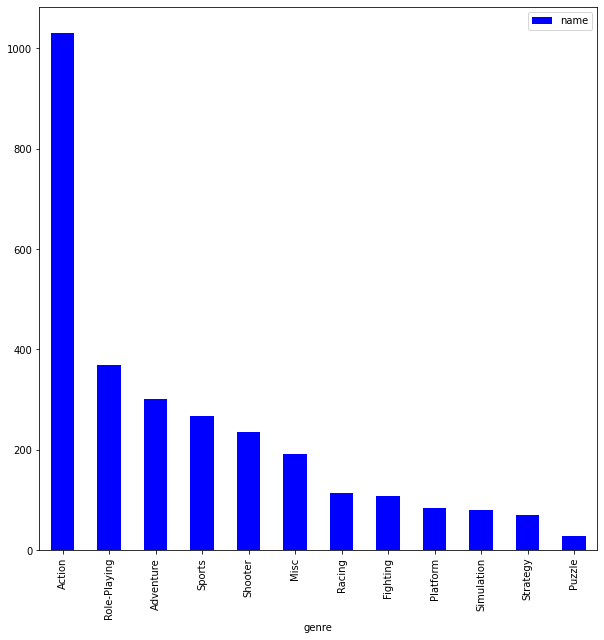

In [53]:
data.pivot_table(index = 'genre', values = 'name', aggfunc='count').sort_values(by = 'name',ascending = False).plot.bar(figsize = (10,10), color = 'blue')

Пиковое значение для жанра экшн можно объяснить тем, что на самом деле файтинги, шутеры и платформеры - это тоже экшн, следовательно так как экшн - это собирательный жанр, то и количество игр для него должно быть больше. Меньше всего игр выходят на досточно узконаправленных жанрах - симуляторы, головоломки и стратегии (важно отметить что многие игры жанра файтинги, шутеры и так далее можно отнести и к стратегиям тоже, чисто стратегическая игра - все-таки узконаправленный жанр), больше всего игр выходят в жанрах экшн, ролевые и путешествия

<AxesSubplot:xlabel='year_of_release'>

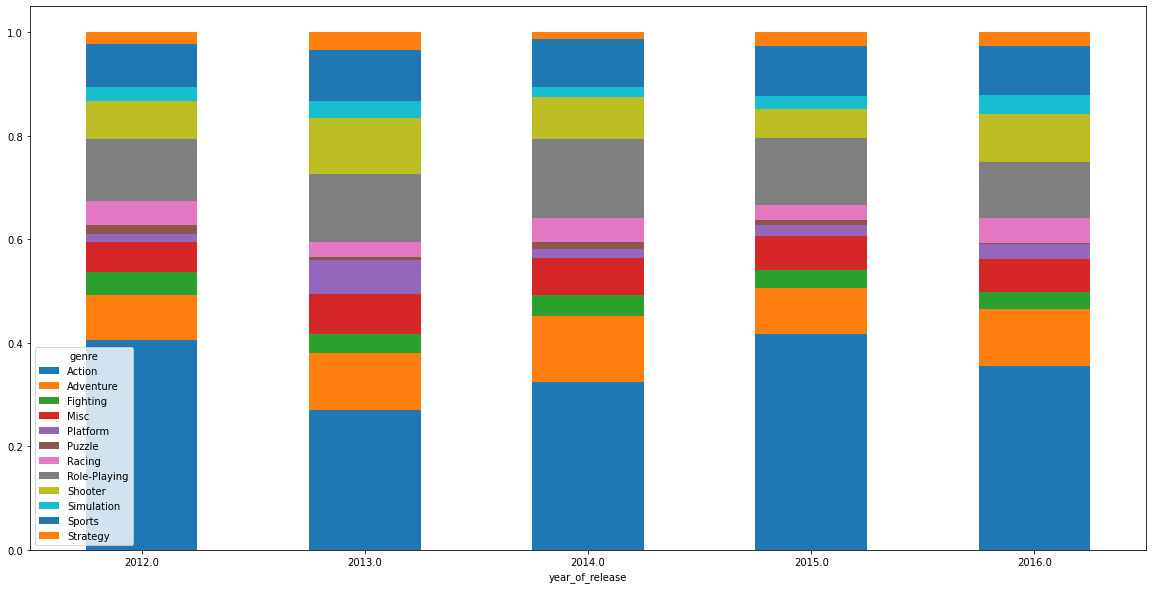

In [54]:
cross_tab_prop = pd.crosstab(index=data['year_of_release'],
                             columns=data['genre'],
                             values = data['name'],
                             aggfunc='count',
                             normalize="index")
cross_tab_prop.plot.bar(rot = 0,figsize = (20,10), stacked = True)

Как мы видим, на данный момент головоломки практически утратили актуальность, в последние года больше выпускается экшна, но в остальном процентное соотношение по жанрам остается +- одинаковым по годам. Посмотрим, теперь на процентное соотношение для количества продаж

<AxesSubplot:xlabel='year_of_release'>

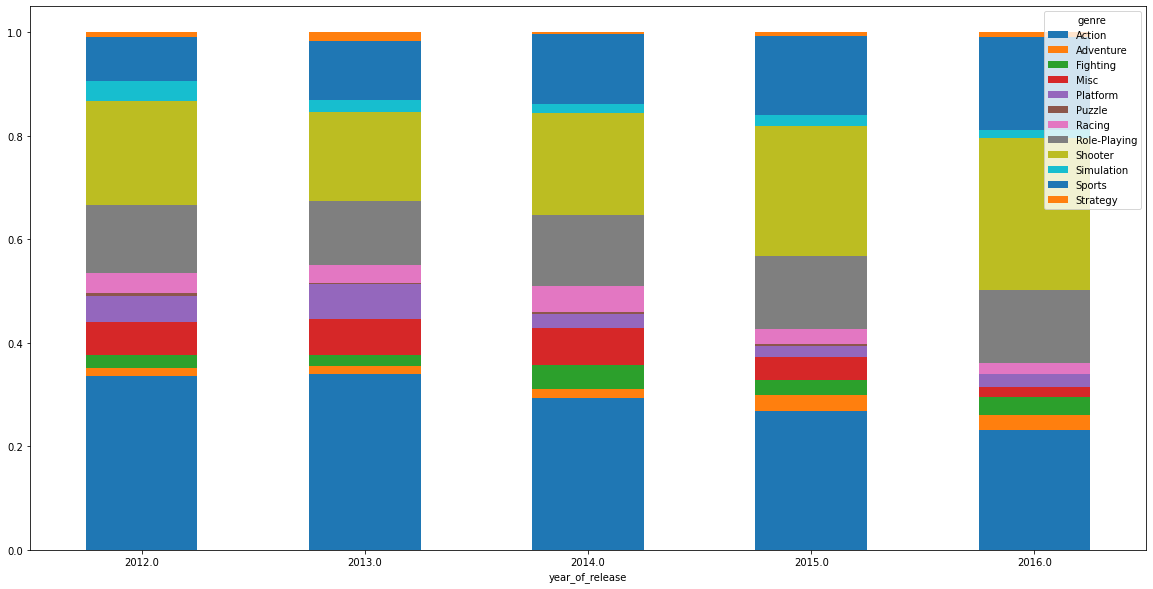

In [55]:
cross_tab_prop = pd.crosstab(index=data['year_of_release'],
                             columns=data['genre'],
                             values = data['total_sales'],
                             aggfunc= 'sum',
                             normalize="index")
cross_tab_prop.plot.bar(rot = 0,figsize = (20,10), stacked = True)

Шутеры не выделялись по количеству выпущенных игр, однако по среднему количеству проданных копий тенденция идет только вверх, получается, игры-шутеры выпускают редко,но метко, в возможно, новые шутеры интереснее,чем новые игры в жанре экшн, но все-таки львиная доля общих проданных копий стабильно относится к играм жанра экшн, также достаточно большой процент во все года относится к играм в жанре спорт, платформенные игры начали немного терять свою актуальность по сравнению с 2012-2013.Игры в жанре приключения выпускаются в достаточно большом проценте, однако процент проданных копий довольно маленький. Соответственно меньше всего копий продается в жанрах стратегия, симуляторы и головоломки, а больше всего - шутеры, экшн, спорт. Однако важно еще учитывать среднее количество проданных копий, для того чтобы сделать вывод об успешных жанрах, которые берут не количеством выпускаемых игр, а качеством

<AxesSubplot:xlabel='year_of_release'>

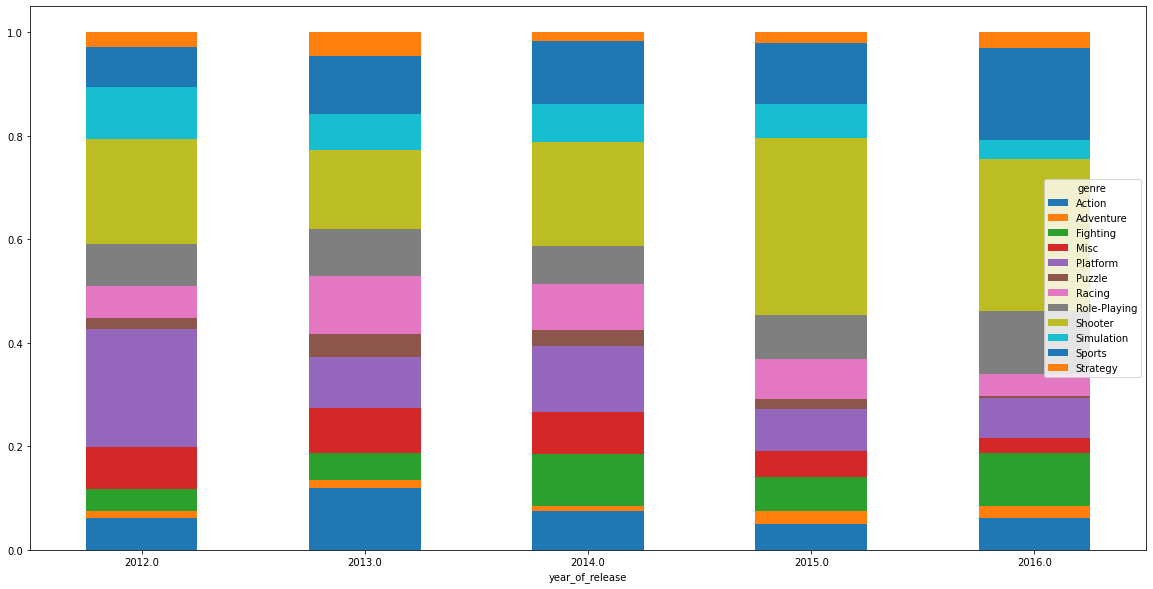

In [56]:
cross_tab_prop = pd.crosstab(index=data['year_of_release'],
                             columns=data['genre'],
                             values = data['total_sales'],
                             aggfunc= 'mean',
                             normalize="index")
cross_tab_prop.plot.bar(rot = 0,figsize = (20,10), stacked = True)

В жанре экшн выпускалось стабильно много игр, однако среднее количество проданных копий неожиданно малое, следовательно в этом жанре штампуют много плохо продаваемых игр, жанр шутеры как и отмечалось ранее очень успешен, неожиданно успешными, несмотря на малое количество выпущенных игр, оказались жанры файтинг и платформер, видимо, это те жанры, игры в которых выпускаются больше не на массовость, а на любителей таких жанров, также в таких жанрах обычно выпускают игры компании, которые на них специализируются, таких компаний не очень много, но они делают качественные игры, жанр спорта также стабильно достаточно успешен. Самые успешные жанры по среднему количеству проданных копий: шутеры, спорт, платформеры. Самые неуспешные - приключения и головоломки

Теперь проанализируем диаграммы размаха для каждого из жанров, чтобы сравнить, насколько стабилен каждый из жанров

<AxesSubplot:xlabel='genre', ylabel='total_sales'>

<Figure size 432x288 with 0 Axes>

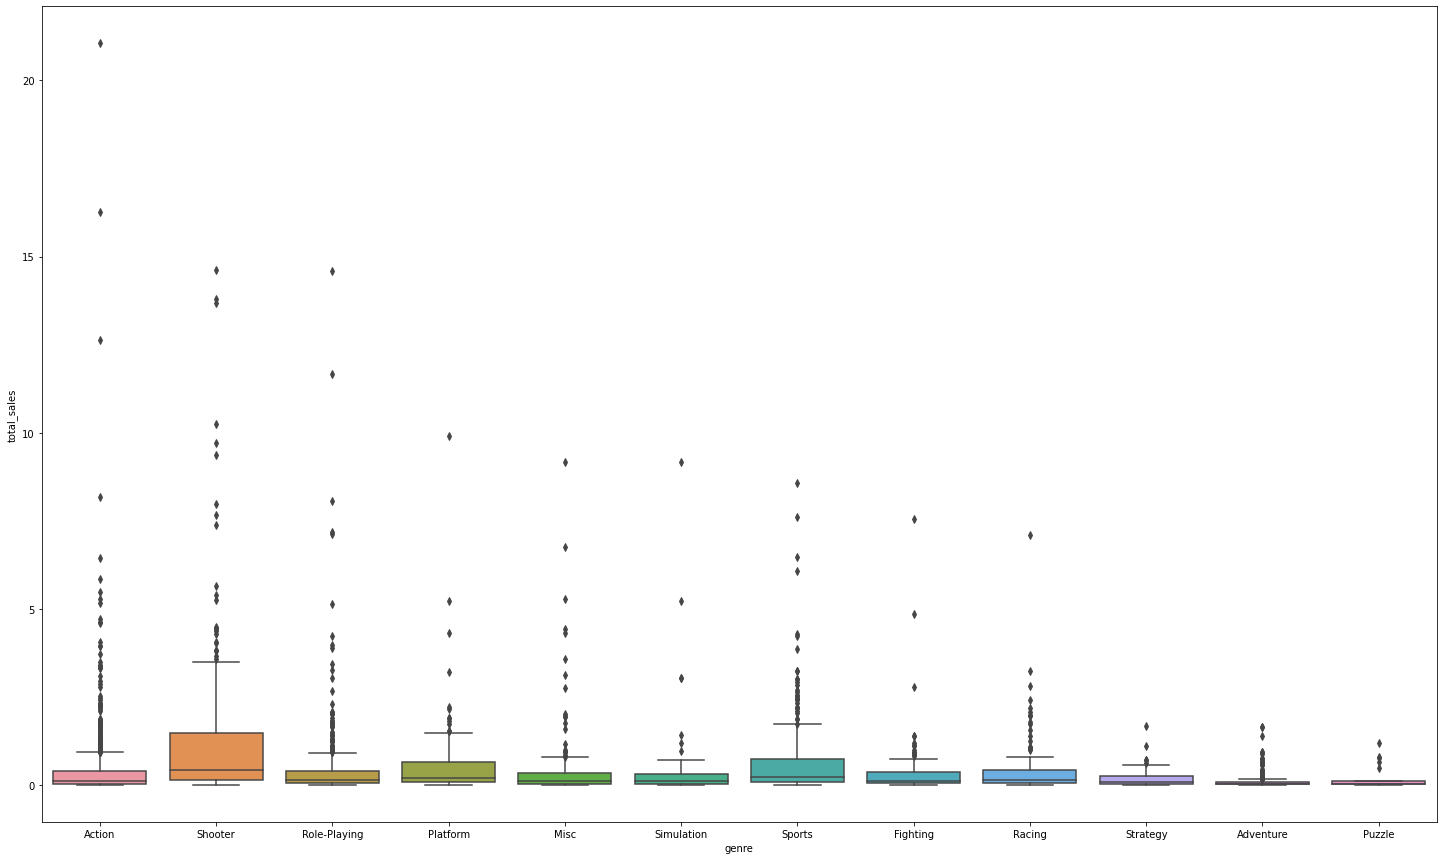

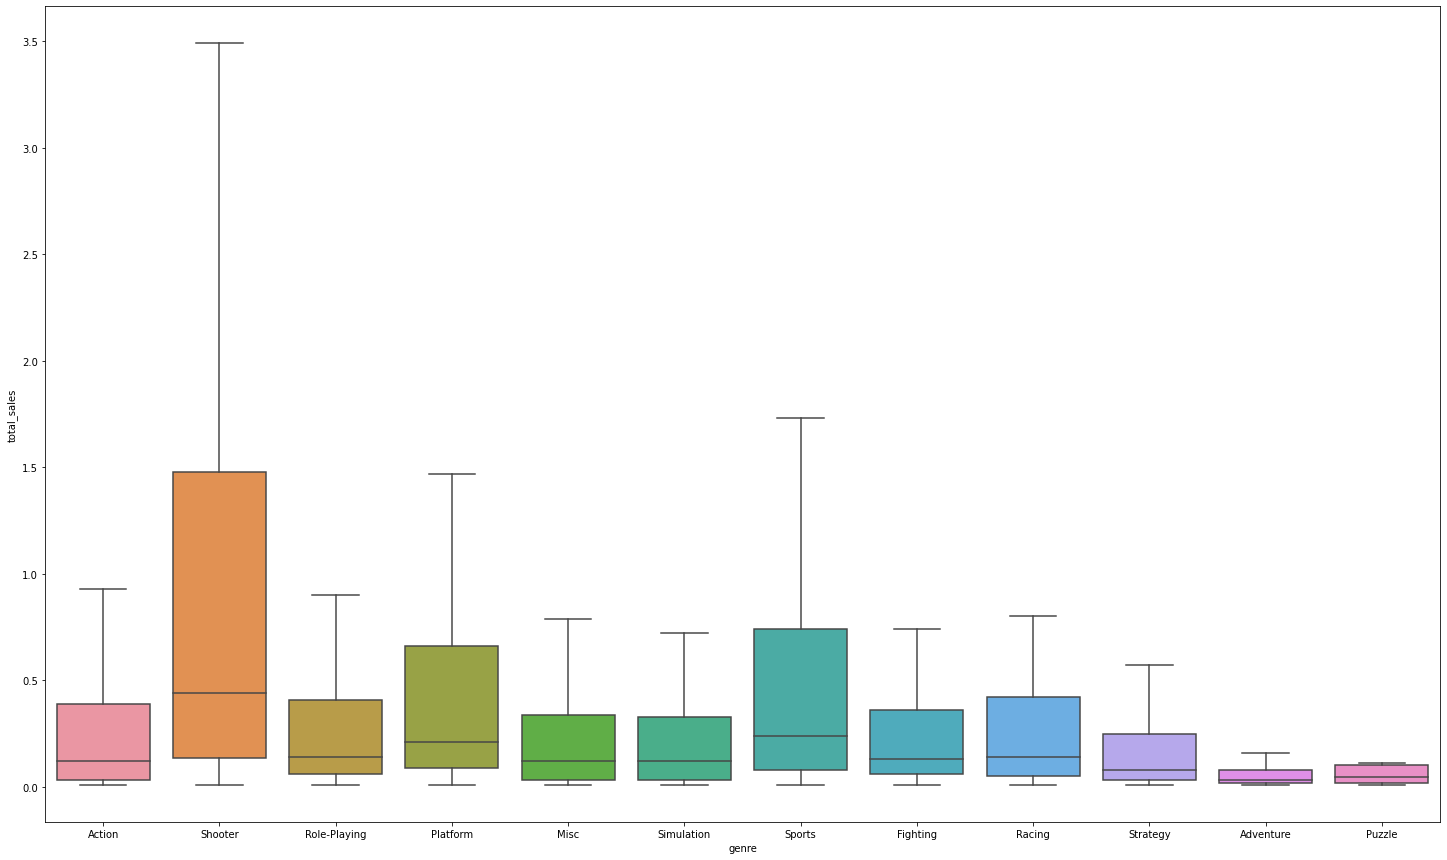

In [57]:
plt.figure(1)
plt.figure(figsize=(25,15))
sns.boxplot(x = 'genre', y = 'total_sales', data = data,showfliers = True)
plt.figure(2)
plt.figure(figsize=(25,15))
sns.boxplot(x = 'genre', y = 'total_sales', data = data,showfliers = False)

Большое количество выбросов мы видим в жанре экшн и ролевые, шутеры также отличаются большими выбросами, самыми успешными играми являются игры в жанре шутеры, у них самые большие квартили, однако несмотря на это и самая большая разбежка в продажах, самые непродаваемые жанры - приключения, головоломки, у них самые низкие квартили, и они не отличаются сильными выбросами, жанрами с хорошо продаваемыми играми можно назвать еще жанры спорт и платформеры

### Портрет пользователя для каждого региона 

Посмотрим на платформы, на которых больше всего проданных игр, для каждого региона

In [58]:
display(data.pivot_table(index = 'platform',values = 'na_sales', aggfunc= 'sum').sort_values(by = 'na_sales',ascending = False))
display(data.pivot_table(index = 'platform',values = 'eu_sales', aggfunc= 'sum').sort_values(by = 'eu_sales',ascending = False))
data.pivot_table(index = 'platform',values = 'jp_sales', aggfunc= 'sum').sort_values(by = 'jp_sales',ascending = False)

,na_sales
platform,
X360,140.05
PS4,108.74
PS3,103.38
XOne,93.12
3DS,55.31
WiiU,38.10
PC,19.12
Wii,17.45
PSV,10.98


,eu_sales
platform,
PS4,141.09
PS3,106.86
X360,74.52
XOne,51.59
3DS,42.64
PC,37.76
WiiU,25.13
Wii,11.92
PSV,11.36


,jp_sales
platform,
3DS,87.79
PS3,35.29
PSV,21.04
PS4,15.96
WiiU,13.01
PSP,10.47
DS,3.72
Wii,3.39
X360,1.57


<AxesSubplot:ylabel='platform'>

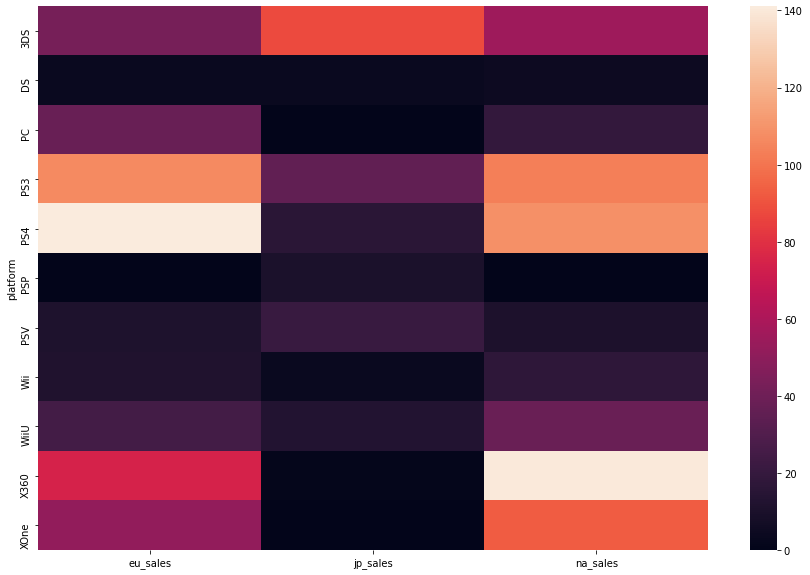

In [59]:
plt.figure(figsize=(15,10))
sns.heatmap(data.pivot_table(index = 'platform',values = ['na_sales','eu_sales','jp_sales'], aggfunc= 'sum'))

Топ-5 популярных платформ в Америке : X360, PS4, PS3, XOne, 3DS 

Топ-5 платформ по количеству проданных копий для Европы: PS4,PS3, X360, XOne, 3DS список совпал со списком для Америки, за исключением того, что PS4 и PS3 имеют выше место в топе Европы, чем Америки, а у X360 место выше в Америке

Топ платформ в Япрнии выглядит иначе, ТОП-5 - 3DS, PS3,PSV,PS4,WiiU. PS4 в Японии не была настолько популярна, как в Америке и Европе, общее количество продаж в 7 раз меньше,чем в Америке. А 3DS в Америке и Европе был далеко не на первом месте. 2 из 5 платформ в топе (1 и 3 место) - это "ручные" консоли, которые больше вписываются в культуру Японии, чем популярные в Америке и Европе PS и XOne (X360), и даже учитывая насколько популярна PS в мире, и учитывая, что компания Sony японская, все равно PS сделали ставку на европейский и американский рынок, что вызвало недовольство в Японии и сравнительно малые продажи у PS4. 

Как мы видим по heatmap, в Японии игр продается гораздо меньше, чем в других районах, и в Японии много платформ с очень малыми продажами, также стоит заметить, что 3DS в Японии, PS4 в Европе и X360 в Америке идут с большим отрывом от остальных платформ, также эта heatmap наглядно показывает, насколько сильно согласовываются Америка и Европа в выборе платформ и как отличается от них Япония

In [60]:
region = ['na_sales','eu_sales','jp_sales']
dfs = []
for i in range(3):
    dfs.append(data.copy())
    top_platforms = list(data.pivot_table(index = 'platform',values = region[i], aggfunc= 'sum').sort_values(by = region[i],ascending = False).index)[:5]
    dfs[-1]['platform'] = dfs[-1]['platform'].where(dfs[-1]['platform'].isin( top_platforms), 'other')

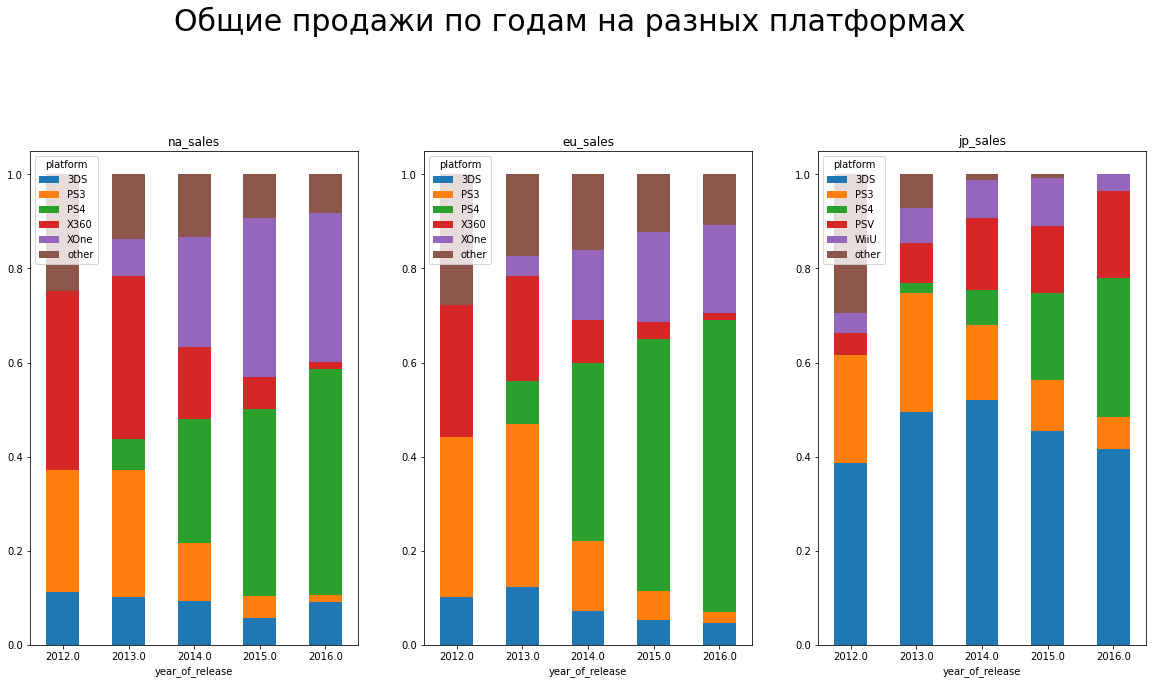

In [61]:
fig = plt.figure(figsize=(20,20))
fig.suptitle('Общие продажи по годам на разных платформах', fontsize = 30)
region = ['na_sales','eu_sales','jp_sales']
ax = []
for i in range(3):
    cross_tab_prop = pd.crosstab(index=dfs[i]['year_of_release'],
                                columns=dfs[i]['platform'],
                                values = dfs[i][region[i]],
                                aggfunc='sum',
                                normalize="index")
    ax1 = plt.subplot(2, 3, i+1)
    cross_tab_prop.plot.bar(ax=ax1,rot = 0, stacked = True)
    ax1.set_title(region[i])
plt.show()

Америка: Очень перспективна на данный момент платформа PS4 и XOne, X360 был крайне популярен в 2012-2013, но сейчас его заменил XOne, продажи PS3 достаточно долго были стабильно хорошими, однако PS3 также заменена PS4, процент продаж игр на платформе 3DS остается стабильным.
Европа: В целом картина примерно такая же, как и в Америке, однако есть свои особенности, например PS3 была более популярна в Европе среди других платформ, X360 не вызвала такого фурора, который был в Америке, XOne тоже не так популярен в Европе, как в Америке. Самые перспективные платормы остаются, как и в Америке - PS4 и XOne.
Япония: Абсолютно другая картина видна в продажах на японском рынке, о популярности X360, огромных процентах от продаж у PS4 можно забыть. Самыми перспективными платформами на данный момент можно считать 3DS, PSV и PS4, хотя ее процент от продаж и не сравнится с другими регионами. Интересный факт: японцы любят играть в дороге, поэтому для них приоритетнее компактные платформы. PSP была популярна в 2010-2011, сейчас же ей на замену пришла PSV. DS пользовалась большой популярностью в 2006-2010 годы, после же на замену пришла 3DS.

Посмотрим также на количество проданных копий по годам в каждом из районов

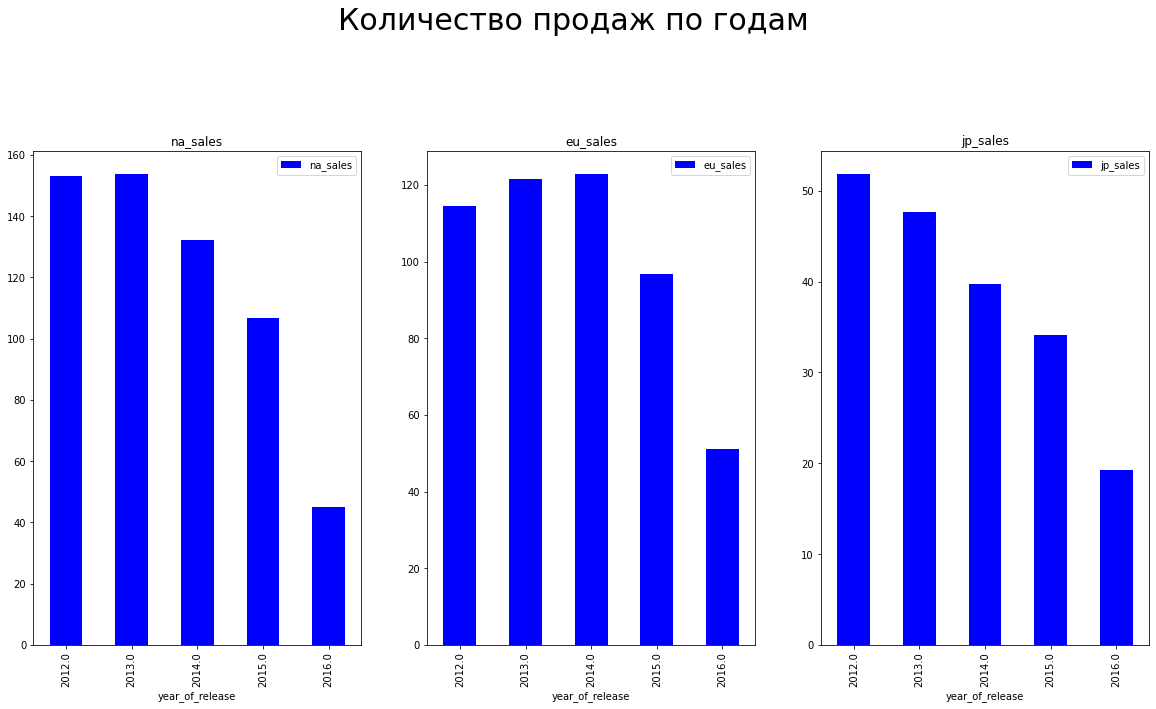

In [62]:
fig = plt.figure(figsize=(20,20))
fig.suptitle('Количество продаж по годам', fontsize = 30)
region = ['na_sales','eu_sales','jp_sales']
for i in range(3):
    ax1 = plt.subplot(2, 3, i+1)
    data.pivot_table(index = 'year_of_release', values = region[i], aggfunc='sum').plot.bar(ax = ax1, color = 'blue')
    ax1.set_title(region[i])
plt.show()

Америка: после 2013 заметен постепенный спад в количестве продаж

Европа: рост количества продаж до 2014, в 2015 уже было продано намного меньше игр

Япония: c 2012 видим постоянный спад количества проданных игр

Теперь посмотрим на самые популярные жанры в регионах

In [63]:
display(data.pivot_table(index = 'genre',values = 'na_sales', aggfunc= 'sum').sort_values(by = 'na_sales',ascending = False))
display(data.pivot_table(index = 'genre',values = 'eu_sales', aggfunc= 'sum').sort_values(by = 'eu_sales',ascending = False))
display(data.pivot_table(index = 'genre',values = 'jp_sales', aggfunc= 'sum').sort_values(by = 'jp_sales',ascending = False))

,na_sales
genre,
Action,177.84
Shooter,144.77
Sports,81.53
Role-Playing,64.00
Misc,38.19
Platform,25.38
Fighting,19.79
Racing,17.22
Adventure,8.92


,eu_sales
genre,
Action,159.34
Shooter,113.47
Sports,69.09
Role-Playing,48.53
Racing,27.29
Misc,26.32
Platform,21.41
Simulation,14.55
Fighting,10.79


,jp_sales
genre,
Role-Playing,65.44
Action,52.80
Misc,12.86
Simulation,10.41
Fighting,9.44
Shooter,9.23
Platform,8.63
Adventure,8.24
Sports,8.01


<AxesSubplot:ylabel='genre'>

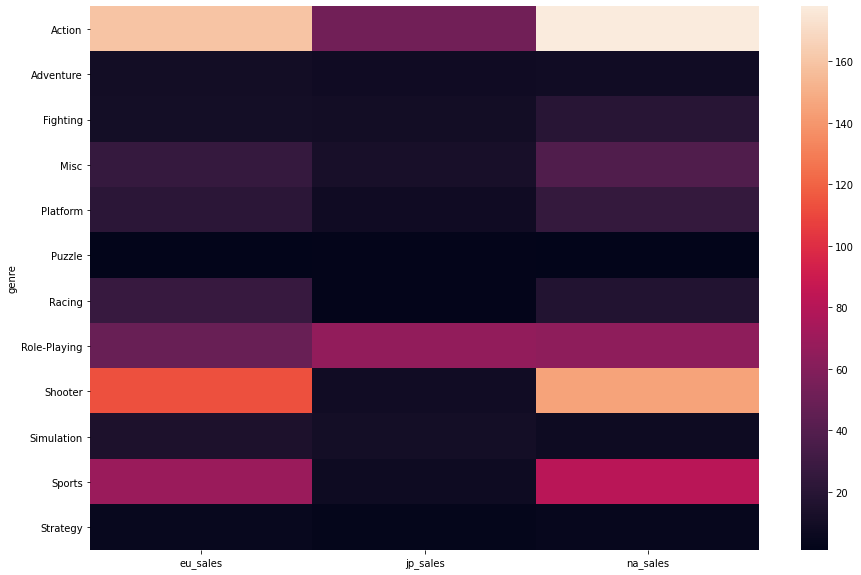

In [64]:
plt.figure(figsize=(15,10))
sns.heatmap(data.pivot_table(index = 'genre',values = ['na_sales','eu_sales','jp_sales'], aggfunc= 'sum'))

Америка: В топ-5 жанров входят: экшн (с большим отрывом, предположительно, потому что это сборный жанр), шутеры,спорт, ролевые и игры без конкретного жанра (другие). 

Европа: Топ-5 жанров - экшн,шутеры, спорт, ролевые, гонки. Список практически идентичный списку для Америки, за исключением того, что гонки тут популярнее

Япония: Состав топ-5 жанров отличается от европейского и американского топа : на первом месте ролевые игры, потом экшн, другие, симуляторы и файтинги. Спорт и гонки находятся в конце списка в отличие от Америки и Европы соответственно, что еще раз указывает на то, что японские предпочтения в играх сильно отличаются от европейских и американских. Ролевые игры больше всего, пожалуй, подходят под характер японцев, существует даже отдельная отраль RPG - JRPG, в которой сюжеты игр очень напоминают сюжеты японских аниме и ближе даже к литературе и кинематографу.

In [65]:
region = ['na_sales','eu_sales','jp_sales']
dfs = []
for i in range(3):
    dfs.append(data.copy())
    top_genres = list(data.pivot_table(index = 'genre',values = region[i], aggfunc= 'sum').sort_values(by = region[i],ascending = False).index)[:5]
    dfs[-1]['genre'] = dfs[-1]['genre'].where(dfs[-1]['genre'].isin( top_genres), 'other')

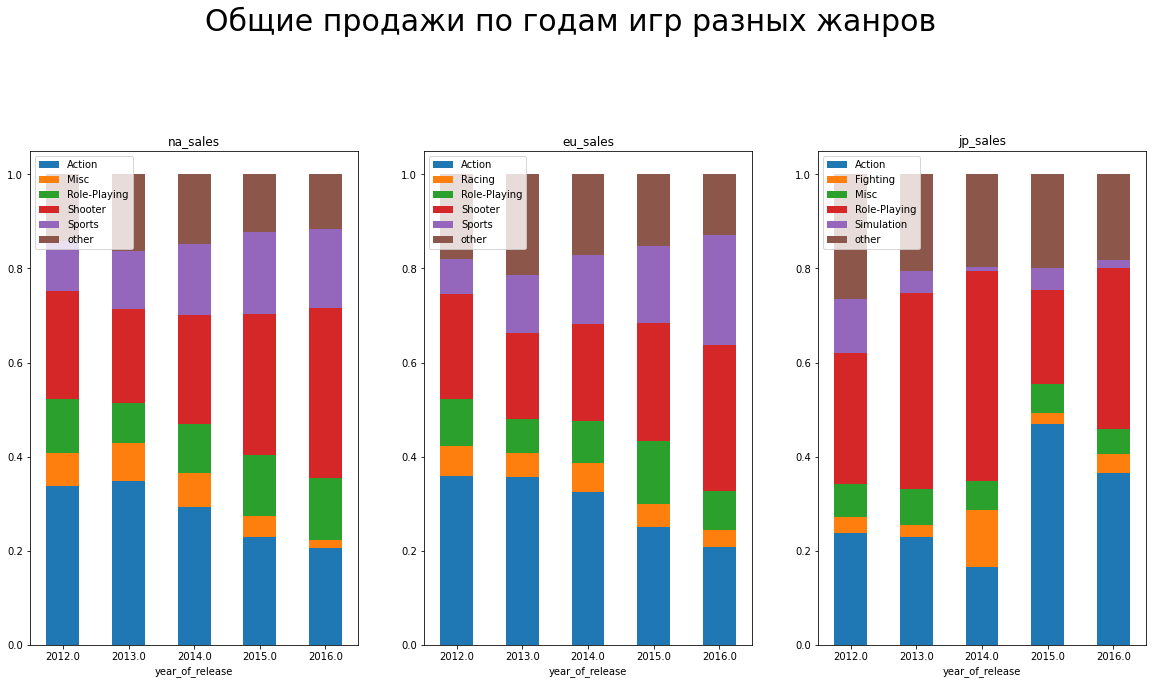

In [66]:
fig = plt.figure(figsize=(20,20))
fig.suptitle('Общие продажи по годам игр разных жанров', fontsize = 30)
region = ['na_sales','eu_sales','jp_sales']
ax = []
for i in range(3):
    cross_tab_prop = pd.crosstab(index=dfs[i]['year_of_release'],
                                columns=dfs[i]['genre'],
                                values = dfs[i][region[i]],
                                aggfunc='sum',
                                normalize="index")
    ax1 = plt.subplot(2, 3, i+1)
    cross_tab_prop.plot.bar(ax=ax1,rot = 0, stacked = True)
    ax1.set_title(region[i])
    ax1.legend(loc = 'upper left')
plt.show()

Америка: Экшн, шутеры и спорт были и остаются стабильно популярными жанрами, в основном популярность жанров каждый год оставалась одной и той же, американцы не изменяют своим предпочтениям. 
Европа: Процентное соотношение для игр по годам практически не меняется, как и у американцев, также картина получается очень похожей на американскую ситуацию, за исключением того, что гонки более популярны в Европе
Япония: Как и ожидалось, ситуация совершенно другая, нежели в прошлых регионах, львиную долю проданных копий каждый год занимают ролевые игры, также в последние два года набрал популярность экшн, симуляторы были гораздо популярнее в 2012-2013, в целом процентное соотношение жанров по годам менее стабильное, чем в других регионах, однако рейтинг каждый год практически идентичный

Теперь проанализируем зависимость продаж от рейтинга ESRB для каждого из регионов

<Figure size 432x288 with 0 Axes>

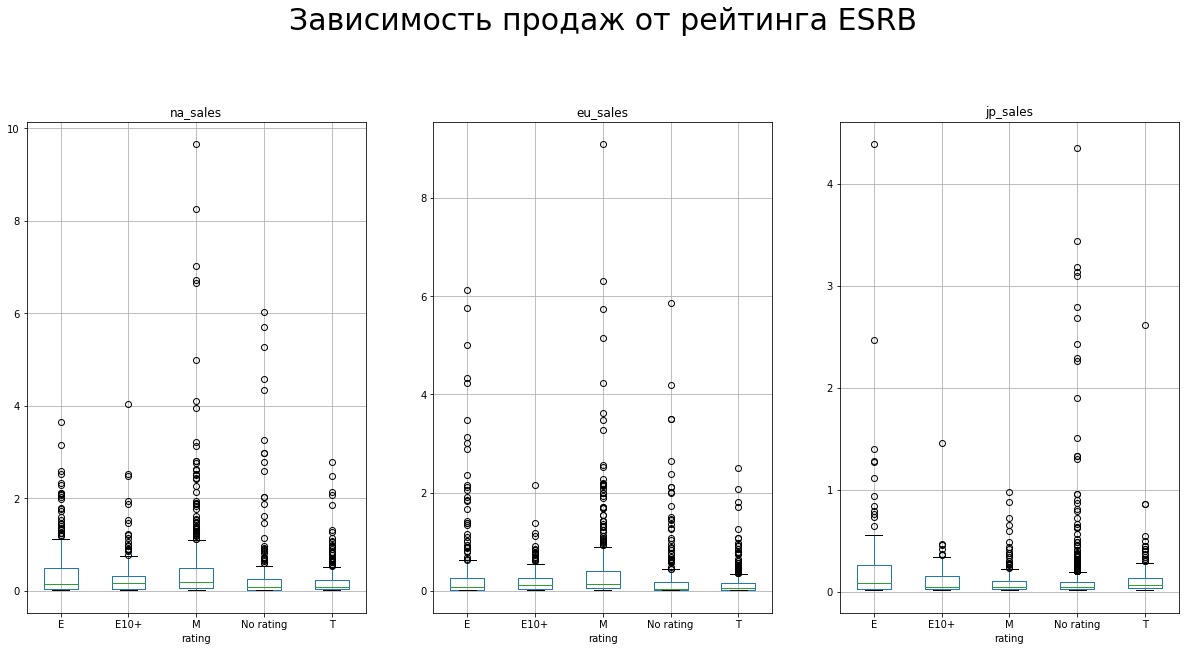

<Figure size 432x288 with 0 Axes>

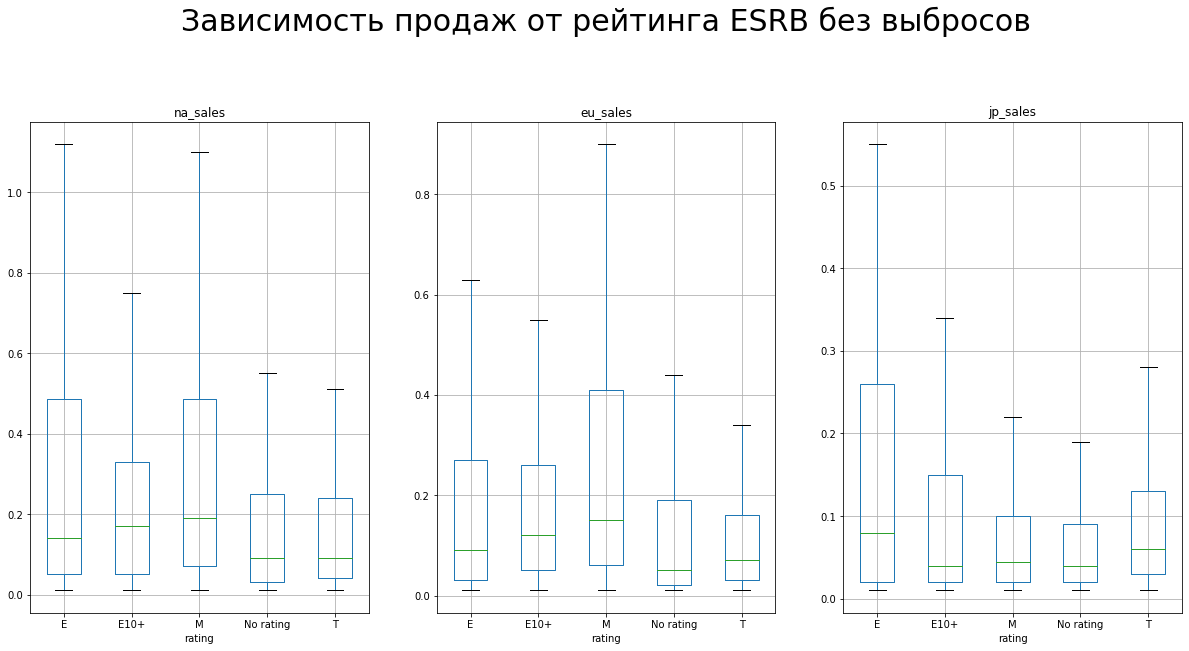

In [67]:
plt.figure(1)
fig = plt.figure(figsize=(20,20))
region = ['na_sales','eu_sales','jp_sales']
for i in range(3):
    ax1 = plt.subplot(2, 3, i+1)
    data[data[region[i]] != 0].boxplot(ax = ax1, column = region[i],by = 'rating', figsize= (15,20))
    ax1.set_title(region[i])
fig.suptitle('Зависимость продаж от рейтинга ESRB', fontsize = 30)
plt.show()
plt.figure(2)
fig = plt.figure(figsize=(20,20))
for i in range(3):
    ax1 = plt.subplot(2, 3, i+1)
    data[data[region[i]] != 0].boxplot(ax = ax1, column = region[i],by = 'rating', figsize= (15,20), showfliers = False)
    ax1.set_title(region[i])
fig.suptitle('Зависимость продаж от рейтинга ESRB без выбросов', fontsize = 30)
plt.show()


Америка: Медианные значения на достаточно низком уровне, как и квартили, практически у всех рейтингов, самая большая разбежка в количестве продаж для 75% у игр с рейтингом M(17+) и E(everyone), самая маленькая разбежка. Видим очень много выбросов практически для каждого возрастного ограничения, то есть это значит, что в популярные и очень продаваемые игры в Америке есть в любых возрастных категориях. Больше всего выбросов у игр для любого возраста, и у игр 17+ и у игр без рейтинга. Самые непродаваемые игры - в жанре T(13+),выбросы там также находятся низко

Европа: Большими продажами, по сравнению с другими рейтингами, выделяется рейтинг M(17+), опять же заметно много выбросов, как и в Америке, больше выбросов у игр с рейтингами M, самые непродаваемые игры - в жанре T(13+), медиана опять же очень низкая

Япония: снова же мы видим абсолютно другую ситуацию, игры с самым большим количеством проданных копий - игры с рейтингом E, то есть для любого возраста. Медианы также достаточно низкие, самые сильные выбросы у игр не имеющих рейтинг, игры с рейтингом M продаются хуже всего, что достаточно логично, японцы не большие любители насилия и подобных вещей в играх. 

### Проверка гипотез

Гипотеза 1: *cредние пользовательские рейтинги платформ Xbox One и PC одинаковые*

In [68]:
data[data['platform'] == 'XOne']['year_of_release'].min()

2013.0

Приставка XOne вышла только в 2013 году, поэтому для того, чтобы выровнять периоды использования платформ, будем рассматривать только данные об играх на PC с 2013

In [69]:
print('Количество игр на платформе Xbox с оценками пользователей = ',len(data[data['platform'] == 'XOne'].dropna(subset = ['user_score'])))
print('Количество игр на платформе PC с оценками пользователей = ',len(data.loc[(data['platform'] == 'PC') & (data['year_of_release'] >= 2013)].dropna(subset = ['user_score'])))

Количество игр на платформе Xbox с оценками пользователей =  182
Количество игр на платформе PC с оценками пользователей =  155


Это гипотеза о равенстве средних двух генеральных совокупностей.

Нулевая гипотеза: среднее пользовательских рейтингов для платформы Xbox One = среднему пользовательских рейтингов для платформы PC.

Альтернативная гипотеза: среднее пользовательских рейтингов для платформы Xbox One != среднему пользовательских рейтингов для платформы PC.

Для проверки этой гипотезы будем использовать метод `scipy.stats.ttest_ind()`, то есть будем использовать t-критерий Уэлча для двух независимых выборок, так как в нашем случае выборки разного размера, генеральные совокупности (пользовательские рейтинги двух платформ) независимы, и благодаря центральной предельной теореме, так как размер наших выборок достаточно большой, выборочные средние каждой генеравльной совокупности распределены нормально 

Критический уровень статистической значимости установим равным 5%

In [70]:
alpha = 0.05
results = st.ttest_ind(
    data[data['platform'] == 'XOne']['user_score'].dropna(), 
    data[data['platform'] == 'PC']['user_score'].dropna(), equal_var=False)
print('p-значение:', results.pvalue)
if results.pvalue < alpha :
    print('Отвергаем нулевую гипотезу')
else:
    print('Нулевую гипотезу не удалось отвергнуть')

p-значение: 0.5489537965134912
Нулевую гипотезу не удалось отвергнуть


Вероятность получить такое же или большее различие, при условии что среднее пользовательских рейтингов для платформы Xbox One = среднему пользовательских рейтингов для платформы PC - p-value - равна более 54%, следовательно мы не можем отвергнуть нулевую гипотезу о равенстве средних двух платформ, исходя из нашего теста, данные не противоречат гипотезе.

Гипотеза 2: *cредние пользовательские рейтинги жанров Action и Sports разные*

In [72]:
print('Количество игр жанра Action с оценками пользователей = ',len(data[data['genre'] == 'Action'].dropna(subset = ['user_score'])))
print('Количество игр жанра Sports с оценками пользователей = ',len(data[data['genre'] == 'Sports'].dropna(subset = ['user_score'])))

Количество игр жанра Action с оценками пользователей =  523
Количество игр жанра Sports с оценками пользователей =  195


Нулевая гипотеза: среднее пользовательских рейтингов жанра Action = среднему пользовательских рейтингов жанра Sports.

Альтернативная гипотеза: среднее пользовательских рейтингов жанра Action != среднему пользовательских рейтингов жанра Sports.

Для проверки этой гипотезы будем использовать метод `scipy.stats.ttest_ind()`, то есть будем использовать t-критерий Уэлча для двух независимых выборок, так как в нашем случае выборки разного размера, генеральные совокупности (пользовательские рейтинги двух жанров) независимы, и благодаря центральной предельной теореме, так как размер наших выборок достаточно большой, выборочные средние каждой генеравльной совокупности распределены нормально 

Критический уровень статистической значимости установим равным 5%

In [73]:
alpha = 0.05
results = st.ttest_ind(
    data[data['genre'] == 'Action']['user_score'].dropna(), 
    data[data['genre'] == 'Sports']['user_score'].dropna(), equal_var=False)
print('p-значение:', results.pvalue)
if results.pvalue < alpha :
    print('Отвергаем нулевую гипотезу')
else:
    print('Нулевую гипотезу не удалось отвергнуть')

p-значение: 4.24307776572644e-20
Отвергаем нулевую гипотезу


Вероятность получить такое же или большее различие, при условии что среднее пользовательских рейтингов жанра Action = среднему пользовательских рейтингов жанра Sports -p-value - очень мала, следовательно мы отвергаем нулевую гипотезу о равенстве средних и принимаем альтернативную гипотезу о неравенстве двух средних. Гипотеза 2 верна.

### Выводы:
Была проведена предобработка данных, а именно : приведение столбцов к нижнему регистру, обработка пропусков, создание столбцов для удобства дальнейшего анализа
Был проведен исследовательский анализ данных, который выявил следующие особенности данных, которые помогут спланировать кампанию магазина на 2017 год
1. После 2011 заметен спад в выпуске новых игр
2. Платформы с наибольшими продажами за все время - PS2, X360,PS3,Wii,DS, однако продажи новых игр на этих платформах очень маленькие, по сравнению с продажами ранее
3. Срок жизни платформ 10-12 лет
4. Был выделен актуальный период для прогнозирования: игры, выпущенные после 2012 года (включительно)
5. Платформы с наибольшими продажами игр с 2012 по 2016 - PS4,PS3,X360,3DS,XOne
6. Наиболее перспективные платформы: PS4,3DS,XOne
7. Большая часть игр на платформах продается очень малым количеством копий, однако практически у каждой платформы есть игры с выдающимися продажами
8. В топе всех платформ много пересечения по играм
9. Зависимости сильной между оценкой критиков и количеством продаж нет, но если оценка критика меньше 60, то тогда это непопулярная игра
10. Зависимость количества продаж от оценки пользователей еще более слабая, но все равно можно утверждать, что если оценка меньше 4, то это в основном непопулярные игры
11. Больше всего игр за этот период с 2012 года было произведено в жанре экшн, также довольно много игр выходят в жанре ролевые игры, меньше всего - симуляторы, головоломки и стратегии
12. На данный момент головоломки практически утратили свою актуальность, все больше выпускается экшна
13. Очень перспективный жанр - шутеры
14. Среднее количество проданных копий достаточно малое для жанра экшн, хотя игр в этом жанре выпускается много
15. Стабильно успешен жанр спорт и платформеры
16. Для Америки и Европы перспективные платформы: PS4, XOne.
17. В Японии продажи меньше, чем в других районах
18. Xbox гораздо менее популярны в Японии, чем в других районах, в Японии предпочтение отдают ручным консолям
19. Самые перспективные платформы в Японии - 3DS,PSV,PS4, 
20. Предпочтения в играх в Японии сильно отличается от других регионов
21. Экшн,шутеры и спорт - стабильно популярные жанры для Америки и Европы, также достаточно популярны ролевые игры
22. Топ жанров в Японии отличается от других районов: на первом месте ролевые игры, потом экшн, симуляторы и файтинги
23. Для Америки самая большая разбежка в количестве продаж для 75% с рейтингом M, самая маленькая - у игр с рейтингом T 
24. Очень продаваемые игры в Америке и Европе есть в любых возрастных категориях
25. В Европе большими продажами выделяется рейтинг M
26. В Японии игры с самым большим количеством проданных копий - игры с рейтингом E, игры с рейтингом M продаются хуже всего
27. Средние пользовательские рейтинги платформ XOne и PC можно считать равными, исходя из проведенного t-теста
28. Средние пользовательские рейтинги жанров Action и Sport разные